In [ ]:
import numpy as np
import torch
import torch.optim as optim
from torch.distributions.bernoulli import Bernoulli
from utils import *

from causalml.inference.meta import BaseDRRegressor
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_theme()


# from tqdm.notebook import tqdm

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")

torch.manual_seed(1)

dim_v = 20
card_u = 5
beta = torch.tensor(list(np.linspace(-5, 5, card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)
trans = torch.rand((dim_v, card_u), dtype=torch.float32)

H = 30
len_seq = 100
num_epoch = 300
T = 100
n = 3000
n_eval = 10000
repeat_num = 5

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0)

# generate sequential data (before manipulation)
seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

In [ ]:
# cutoff rule
def cutoff(card_u, beta, n_eval, cost_coef=0.05):
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")    
    # global access u_eval, v_eval
    u_eval_shift = manipulation_cutoff(u_eval, v_eval, n_eval, card_u, beta, c=cost_coef)
    x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
    tau_eval = x_eval @ beta
    pi_eval = torch.where(tau_eval > 0, torch.tensor(1), torch.tensor(0))
    value = torch.mean(pi_eval * tau_eval)
    return value.item()

In [ ]:
init_u_list = []
mani_u_list = []

def VanillaGD(seed, dim_v, card_u, beta, T, n, n_eval, lr_pi = 0.1, cost_coef=0.05):
    print(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    torch.cuda.manual_seed_all(seed)    
    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    
    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())    

    seq_revenue = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    for t in range(T):
        u, v = dataset[seed][t]
        _, _, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)
        init_u_list.append(u)
        mani_u_list.append(u_shift)

        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta)

        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)
        
        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()        
        revenue = - torch.mean(pi * (tau.detach()))

        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi)

        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)

        seq_revenue.append(value.item())

    # save an instance
    if seed == 0:
        torch.save(model_pi, "models/vani_model_pi_cc_{}.pkl".format(cost_coef))
    
    return seq_revenue

In [ ]:

def End2endGD(seed, dim_v, card_u, beta, H, len_seq, num_epoch, T, n, n_eval, lr_pi = 0.1, lr_prob = 0.05, cost_coef=0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)    
    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    
    dim_theta = nn.utils.parameters_to_vector(model_pi.parameters()).detach().shape[0]
    num_hiddens_prob = 2 * (dim_v + dim_theta)
    model_prob = shifted_distribution(dim_v + dim_theta, num_hiddens_prob, card_u)
    patience = 2

    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())
    
    stop_flag = 0
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs_for_behavior = []
    # seq_inputs_for_policy = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)
    
    for t in range(H):
        u, v = dataset[seed][t]
        inputs_for_behavior, inputs_for_policy, u_category, u_shift = manipulation_theta(u, v, n, card_u, model_pi, c=cost_coef)
        seq_inputs_for_behavior.append(inputs_for_behavior)
        seq_category.append(u_category)

        if len(seq_inputs_for_behavior) > len_seq:
            seq_inputs_for_behavior.pop(0)
            seq_category.pop(0)

        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta)

        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()
        revenue = - torch.mean(pi * tau.detach())
        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, _, u_eval_shift = manipulation_theta(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)

        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)

        seq_revenue.append(value.item())

    # training of the shifted distribution
    stacked_inputs = torch.cat(seq_inputs_for_behavior, dim=0)    
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]

    n_sample = int(stacked_inputs.shape[0] * 0.8)

    # notice that we use detach theta inputs for behavior model
    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]
    val_inputs = stacked_inputs[n_sample:, :]
    val_category = stacked_category[n_sample:, :]

    early_stop_counter = 0
    best_val_loss = float('inf')

    loss_function = nn.CrossEntropyLoss()
    optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)
    for epoch in range(num_epoch):
        loss = loss_function(model_prob(train_inputs), train_category.view(-1))
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()
        seq_loss.append(loss.item())
        loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
        seq_val.append(loss_val.item())
        
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if early_stop_counter >= patience:
            break

    optimizer_pi = optim.SGD(model_pi.parameters(), lr=lr_pi)     
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        inputs_for_behavior, inputs_for_policy, u_category, u_shift = manipulation_theta(u, v, n, card_u, model_pi, c=cost_coef)

        seq_inputs_for_behavior.append(inputs_for_behavior)
                
        seq_category.append(u_category)

        if len(seq_inputs_for_behavior) > len_seq:
            seq_inputs_for_behavior.pop(0)        
            seq_category.pop(0)

        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta)

        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        tau = cate_predict(x, pi, cate_learner).cuda()
        log_prob = nn.LogSoftmax(dim=1)(model_prob(inputs_for_policy))[torch.arange(n), u_category.view(-1)]

        revenue = - torch.mean(pi * tau) - torch.mean(pi.detach() * tau * log_prob)        
        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, _, u_eval_shift = manipulation_theta(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)

        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

        if t >= T - 1:
            break
    
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='loss')
    plt.plot(seq_val, label='val')
    plt.legend()
    plt.show()   
    
    if seed == 0:
        torch.save([seq_revenue, seq_loss, seq_val], "train_curve_e2e.pkl")        
        torch.save(model_pi, "models/e2e_model_pi_cc_{}.pkl".format(cost_coef))
        torch.save(model_prob, "models/e2e_model_prob_cc_{}.pkl".format(cost_coef))            

    return seq_revenue

In [ ]:
mani_u_list_mm = []


def StrategicGD(seed, dim_v, card_u, beta, H, len_seq, num_epoch, T, n, n_eval, lr_pi = 0.01, lr_prob = 0.01, cost_coef = 0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)    

    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    num_hiddens_prob = 2 * (dim_v + card_u)
    model_prob = shifted_distribution(card_u, num_hiddens_prob, card_u)

    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())
    
    patience = 3
    
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    for t in range(H):
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)
        mani_u_list_mm.append(u_shift)
            
        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x) 
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        inputs = inputs[:,-card_u:] # only need zeta as input
        
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()            
        revenue = - torch.mean(pi * tau.detach())
        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy    
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

    # training of the shifted distribution
    stacked_inputs = torch.cat(seq_inputs, dim=0)
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]
    n_sample = int(stacked_inputs.shape[0] * 0.8)

    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]
    val_inputs = stacked_inputs[n_sample:, :]
    val_category = stacked_category[n_sample:, :]

    early_stop_counter = 0
    best_val_loss = float('inf')

    loss_function = nn.CrossEntropyLoss()
    optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)
    
    for epoch in range(num_epoch):
        loss = loss_function(model_prob(train_inputs), train_category.view(-1))
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()
        seq_loss.append(loss.item())
        loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
        seq_val.append(loss_val.item())
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    print("Final Training Loss: %.3f"%loss_val.item())
    print("Epoch: %d"%epoch)
    
    optimizer_pi = optim.Adagrad(model_pi.parameters(), lr=lr_pi)     
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)  
        inputs = inputs[:,-card_u:] 
        
        # record u after manipulation
        mani_u_list_mm.append(u_shift)                
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)

        if len(seq_inputs) > len_seq:
            seq_inputs.pop(0)
            seq_category.pop(0)

        # train model pi
        x = torch.cat((u_shift, v), dim=1)        
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        pi = model_pi(x)  

        
        log_prob = nn.LogSoftmax(dim=1)(model_prob(inputs))[torch.arange(n), u_category.view(-1)]              
        tau = cate_predict(x, pi, cate_learner).cuda()     
        revenue = - torch.mean(pi * tau) -  torch.mean(pi.detach() * tau * log_prob)            
        optimizer_pi.zero_grad()
        revenue.backward(retain_graph=True)                        
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())
            
        if t >= T - 1:
            break
            
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='train loss')
    plt.plot(seq_val, label='val loss')
    plt.legend()
    plt.show()
    
    if seed == 0:
        torch.save([seq_revenue, seq_loss, seq_val], "train_curve_spg.pkl")
        torch.save(model_pi, "models/model_pi_cc_{}.pkl".format(cost_coef))
        torch.save(model_prob, "models/model_prob_cc_{}.pkl".format(cost_coef))            

    return seq_revenue


0.15
0
Final Training Loss: 1.186
Epoch: 267
break converge at epoch 41
break converge at epoch 43
break converge at epoch 49


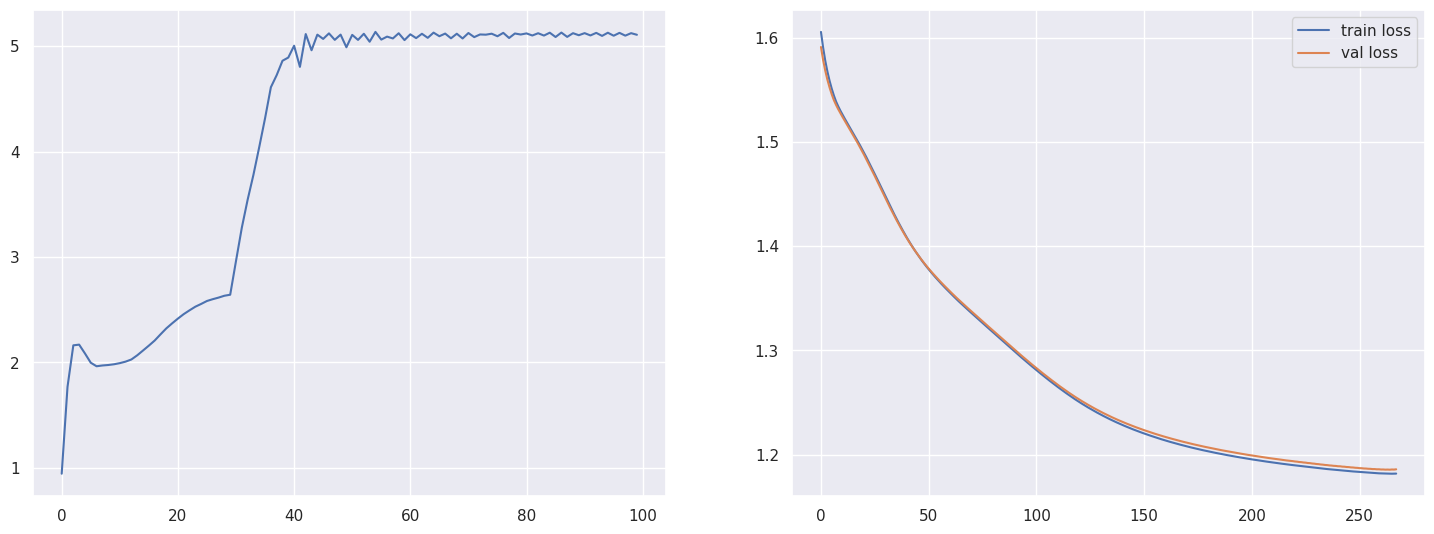

0


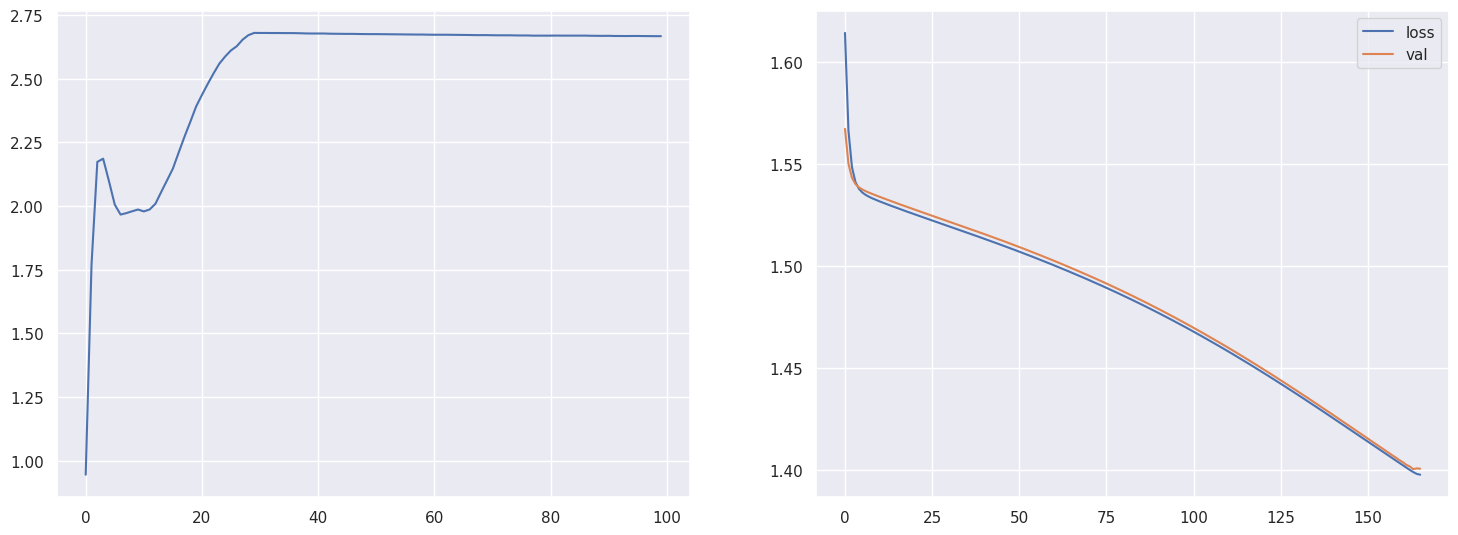

0
1
Final Training Loss: 1.227
Epoch: 299


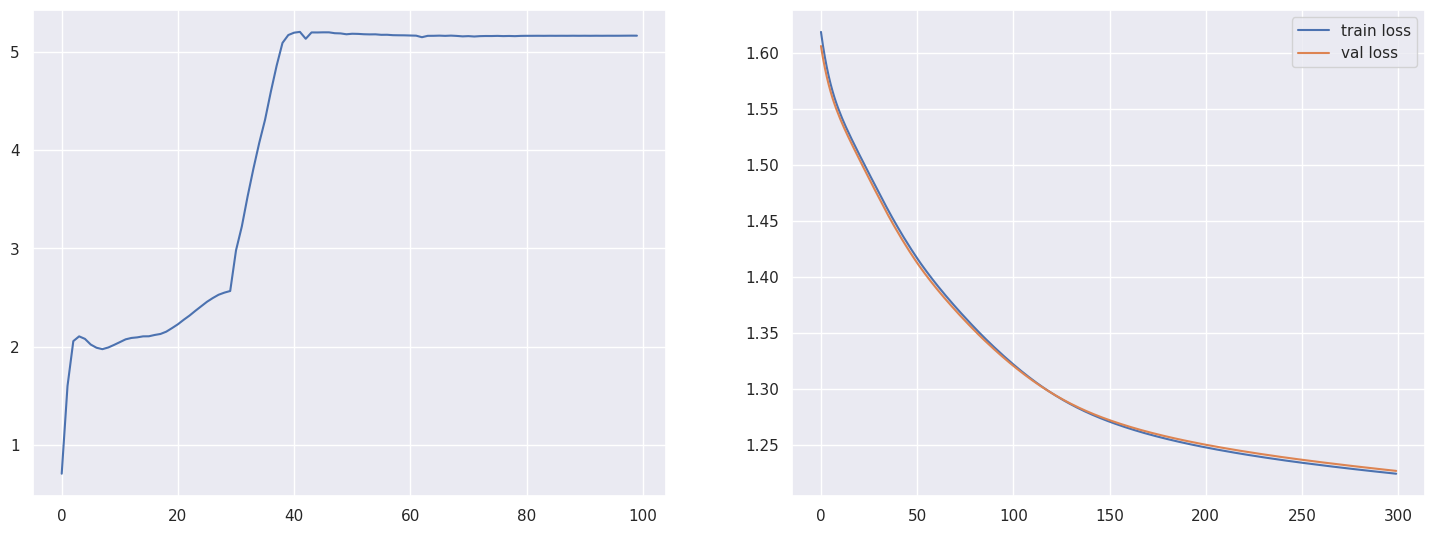

1


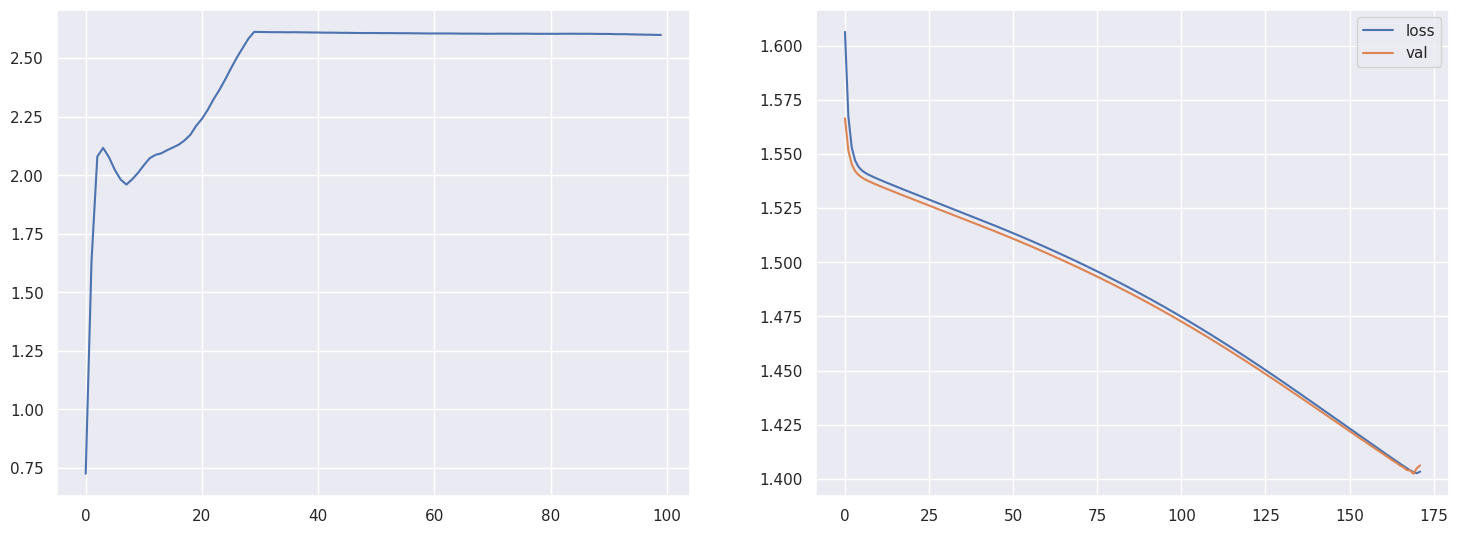

1
2
Final Training Loss: 1.199
Epoch: 291
break converge at epoch 40


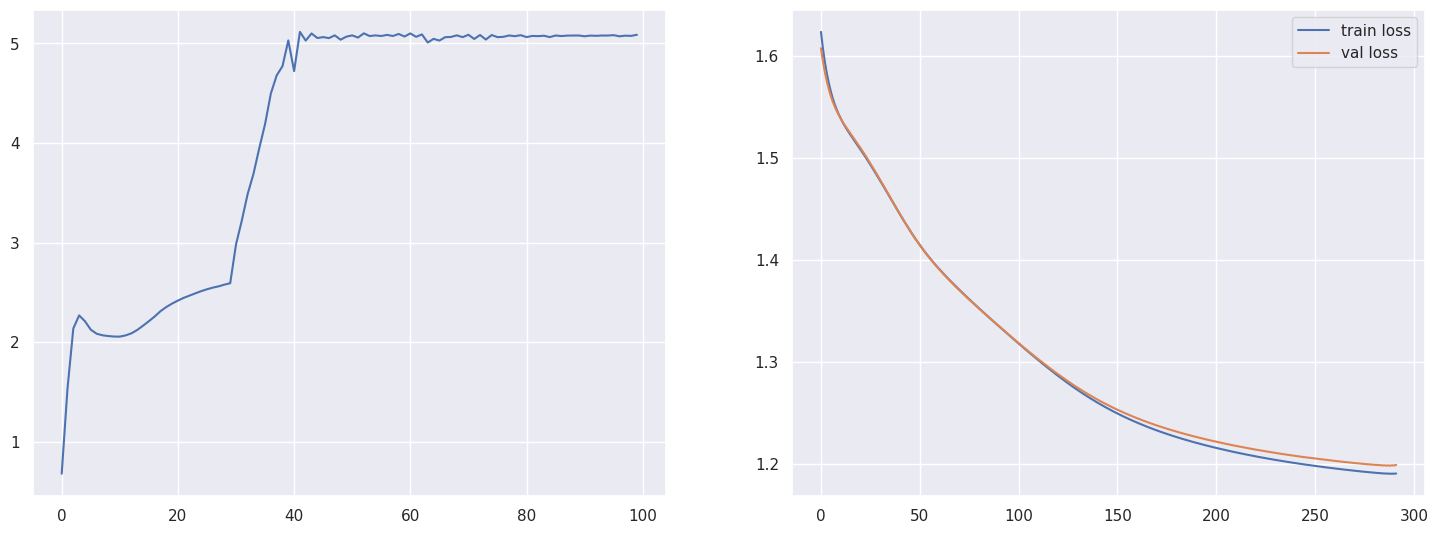

2


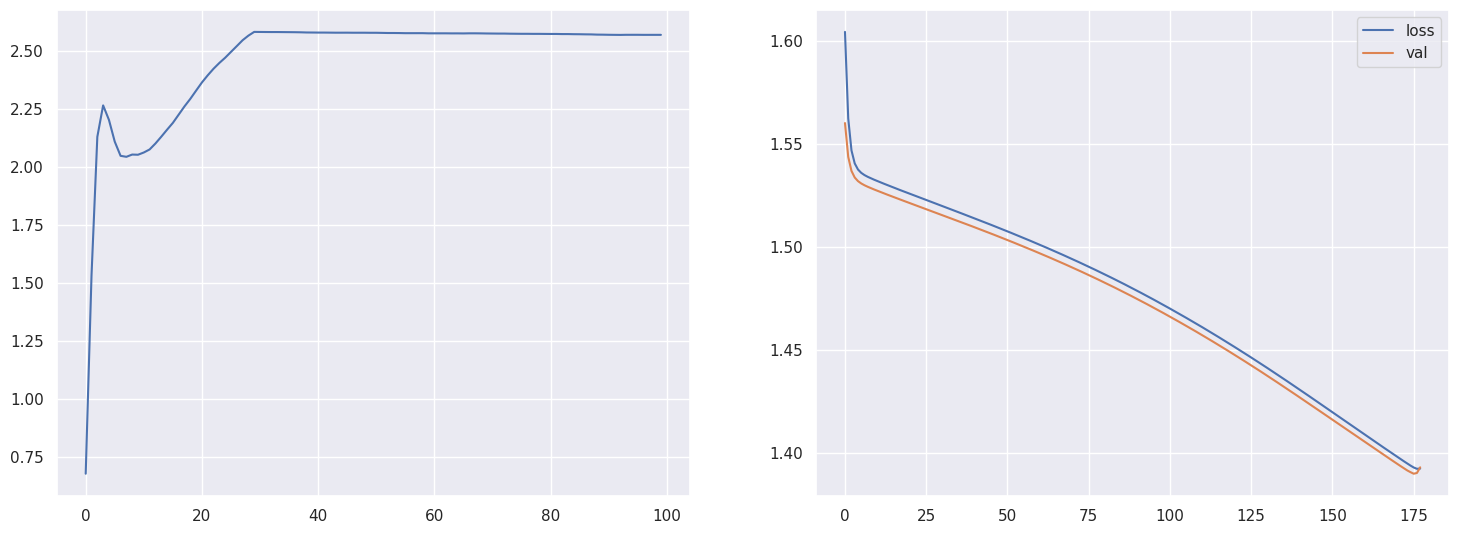

2
3
Final Training Loss: 1.201
Epoch: 299
break converge at epoch 46
break converge at epoch 52
break converge at epoch 56


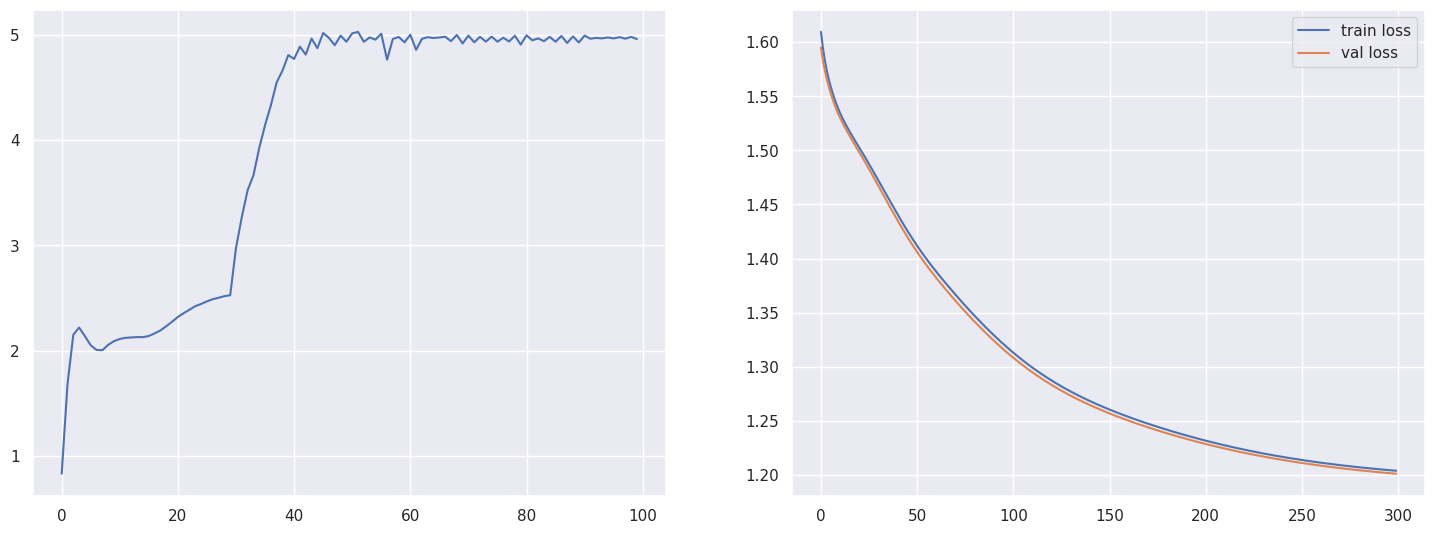

3


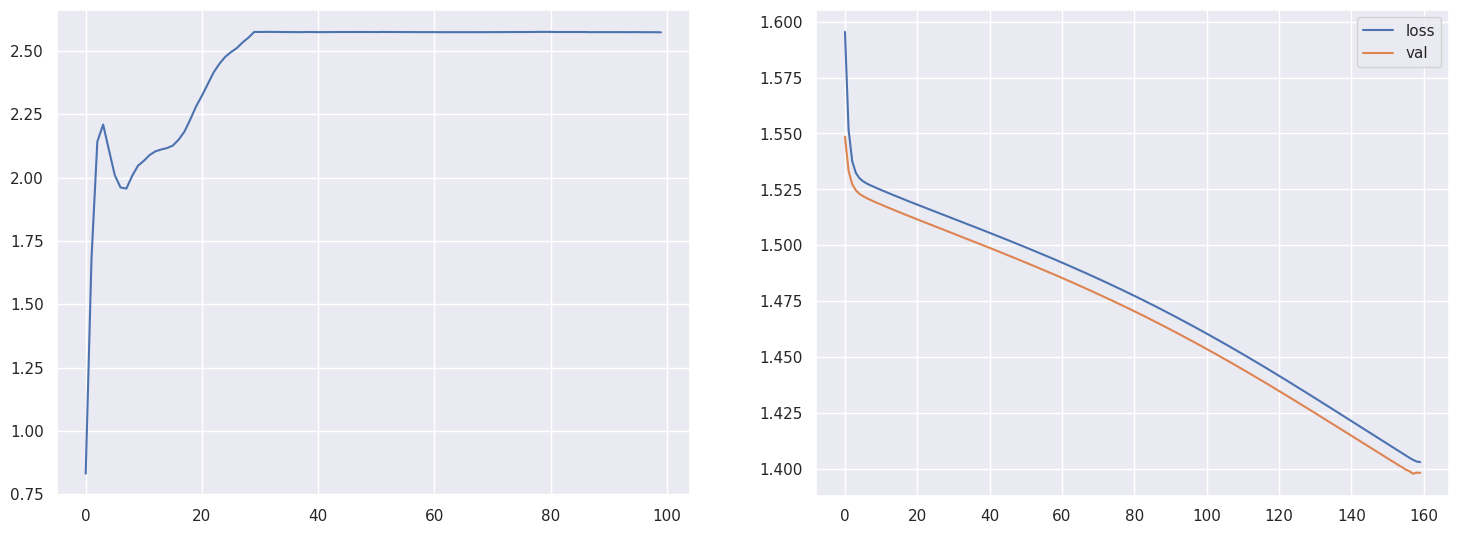

3
4
Final Training Loss: 1.225
Epoch: 210


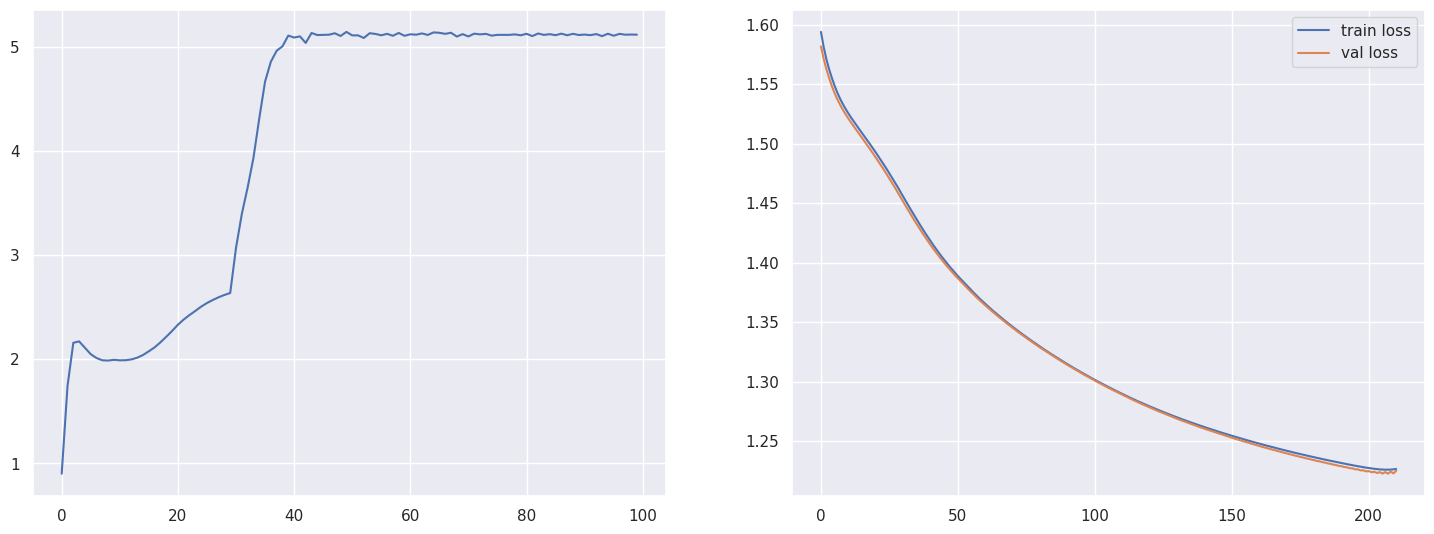

4


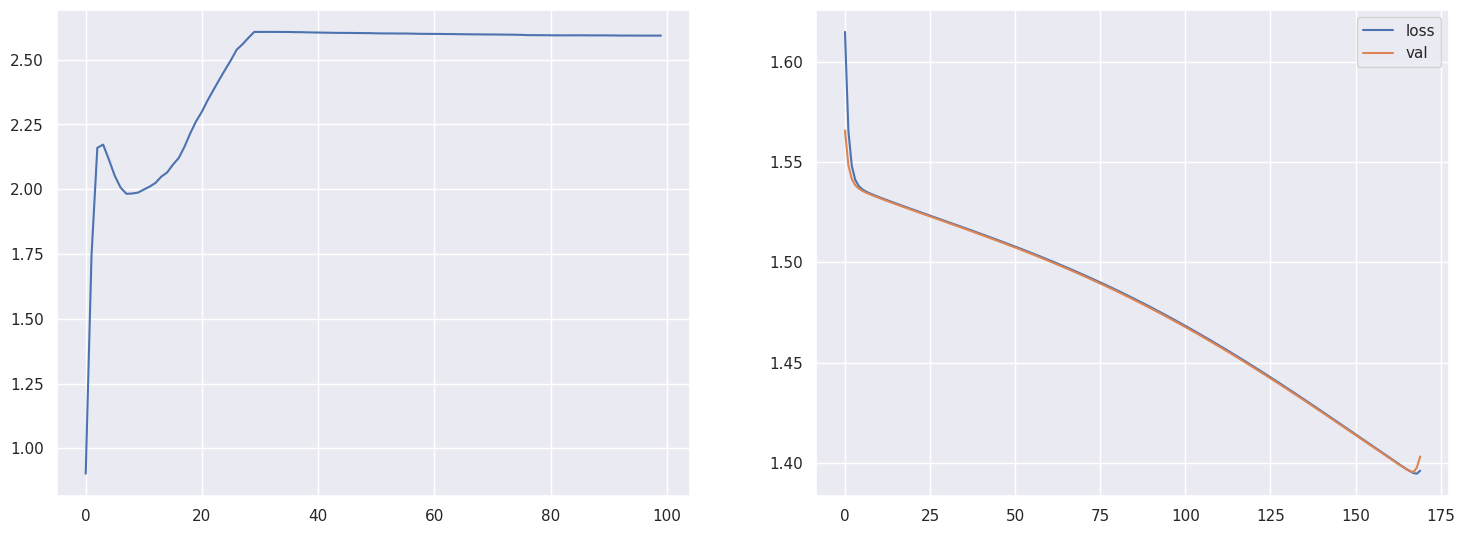

4
5
Final Training Loss: 1.225
Epoch: 299


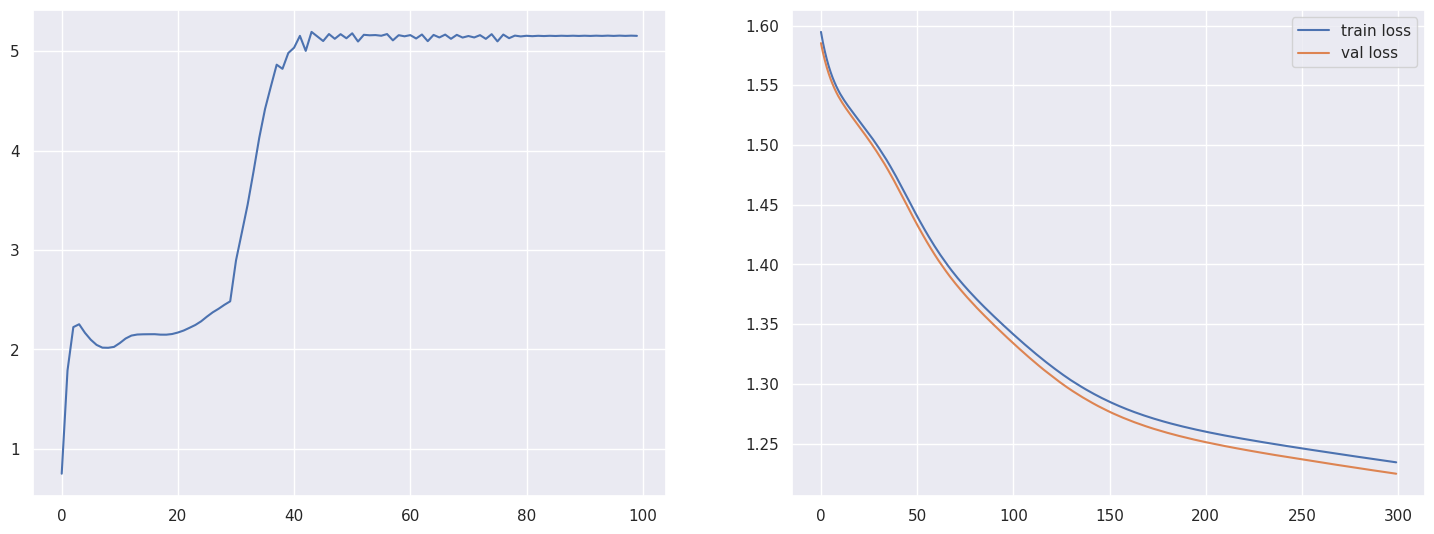

5


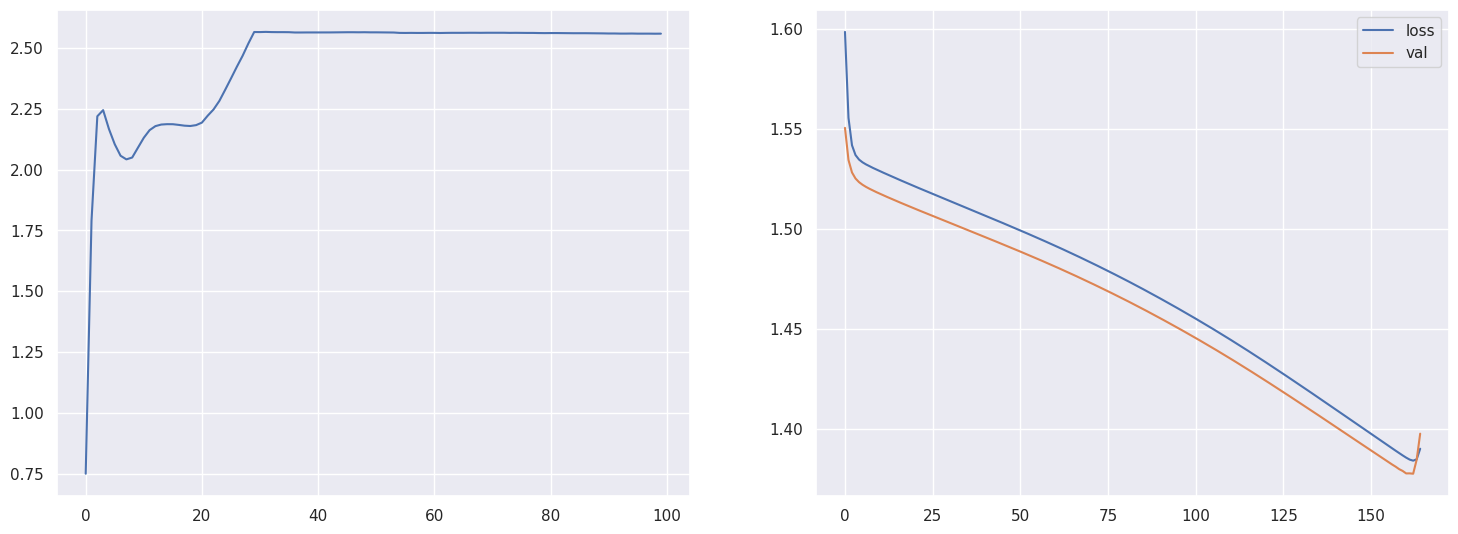

5
6
Final Training Loss: 1.214
Epoch: 299
break converge at epoch 40


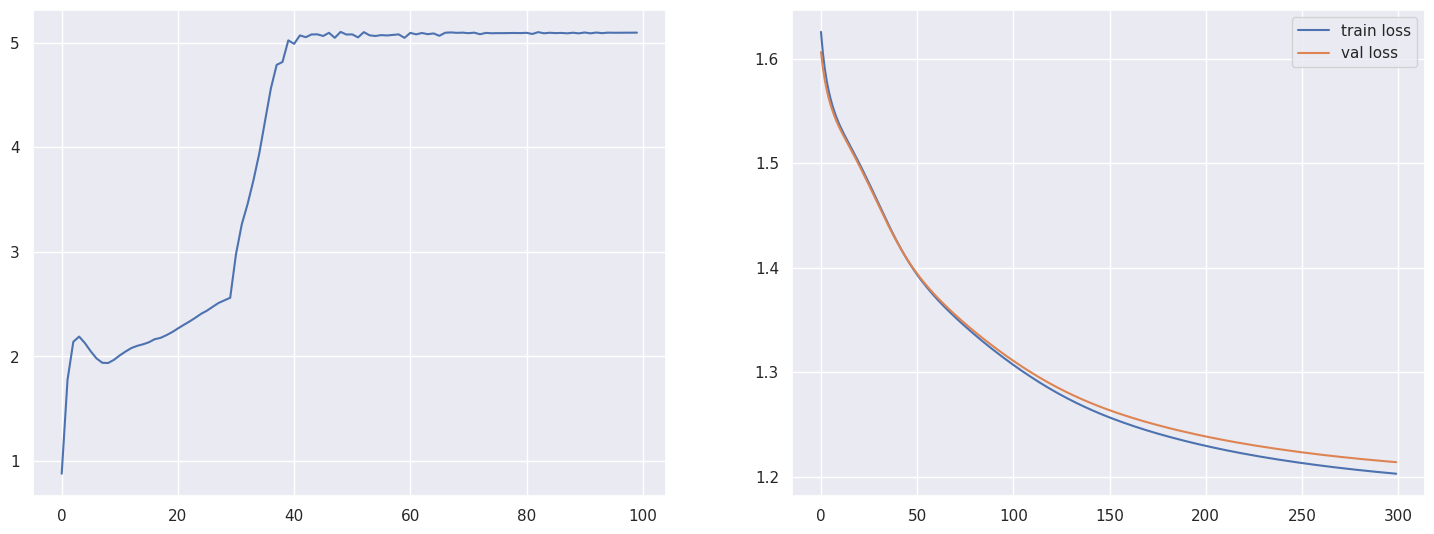

6


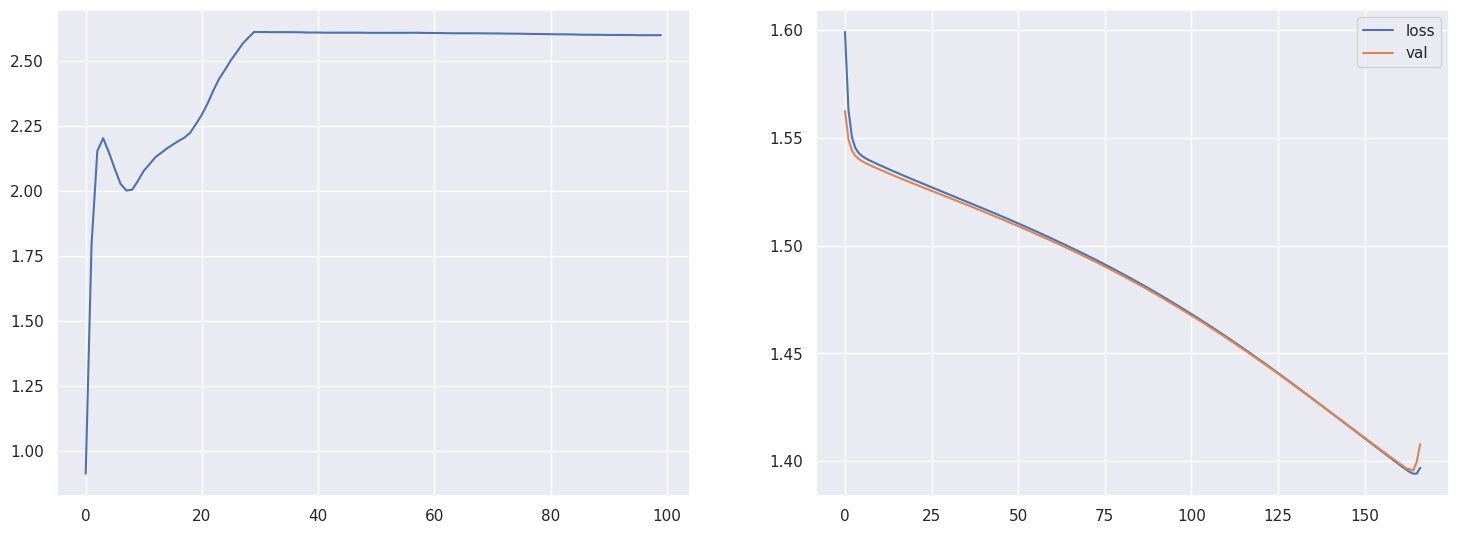

6
7
Final Training Loss: 1.203
Epoch: 198


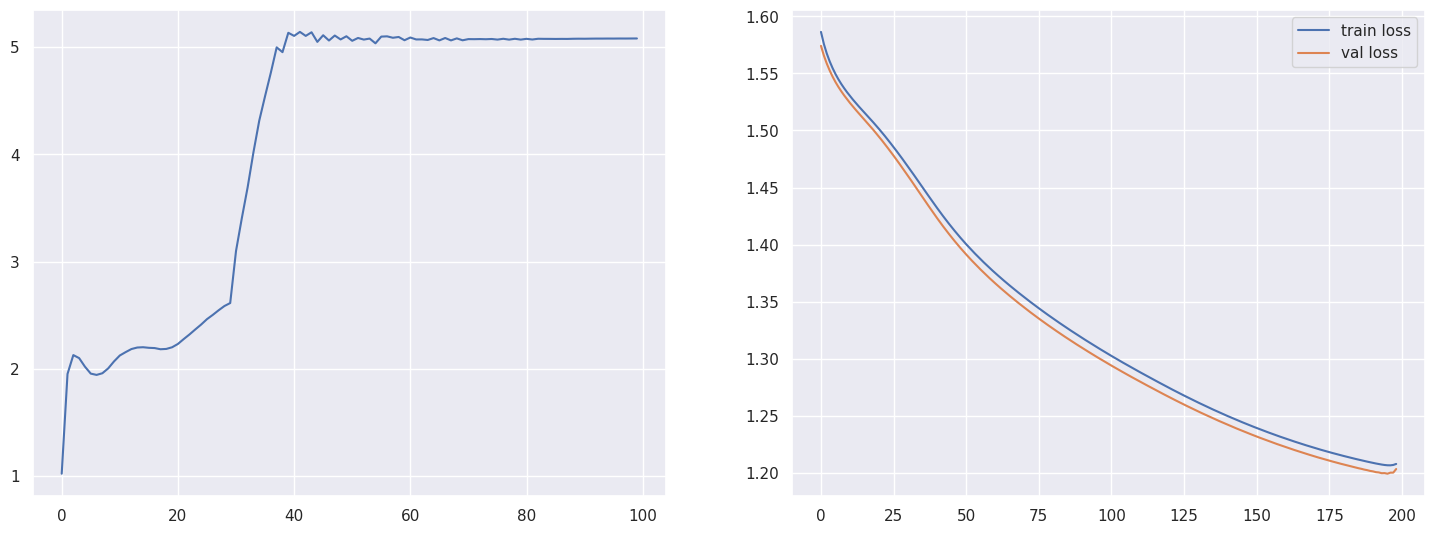

7


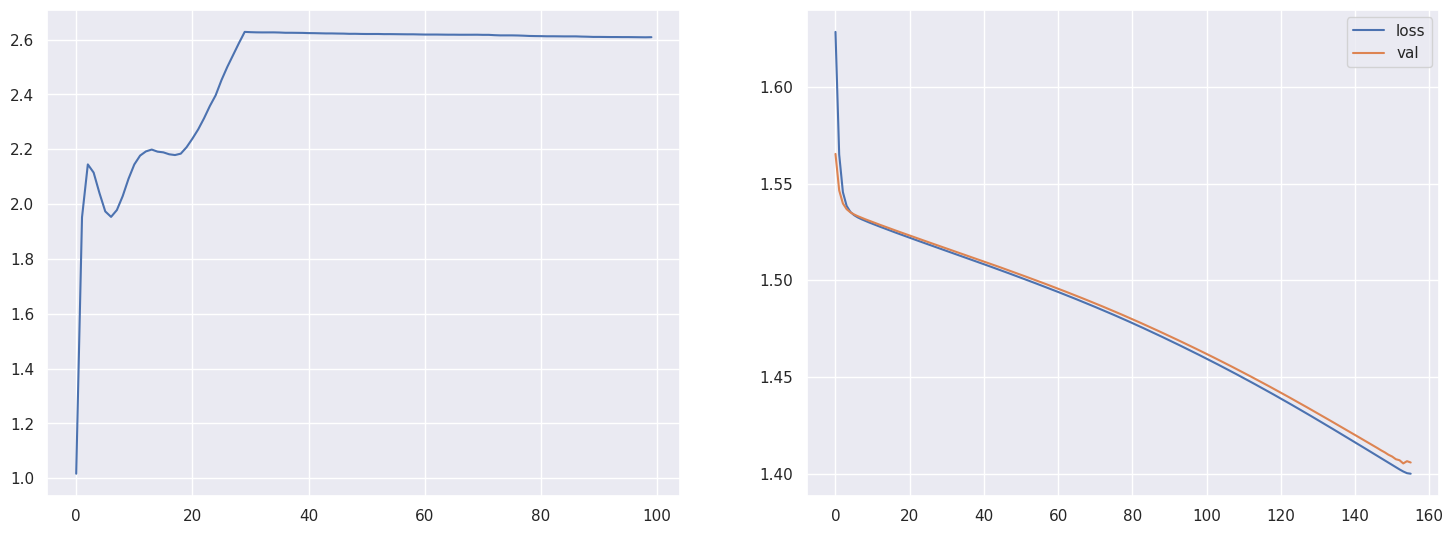

7
8
Final Training Loss: 1.222
Epoch: 299


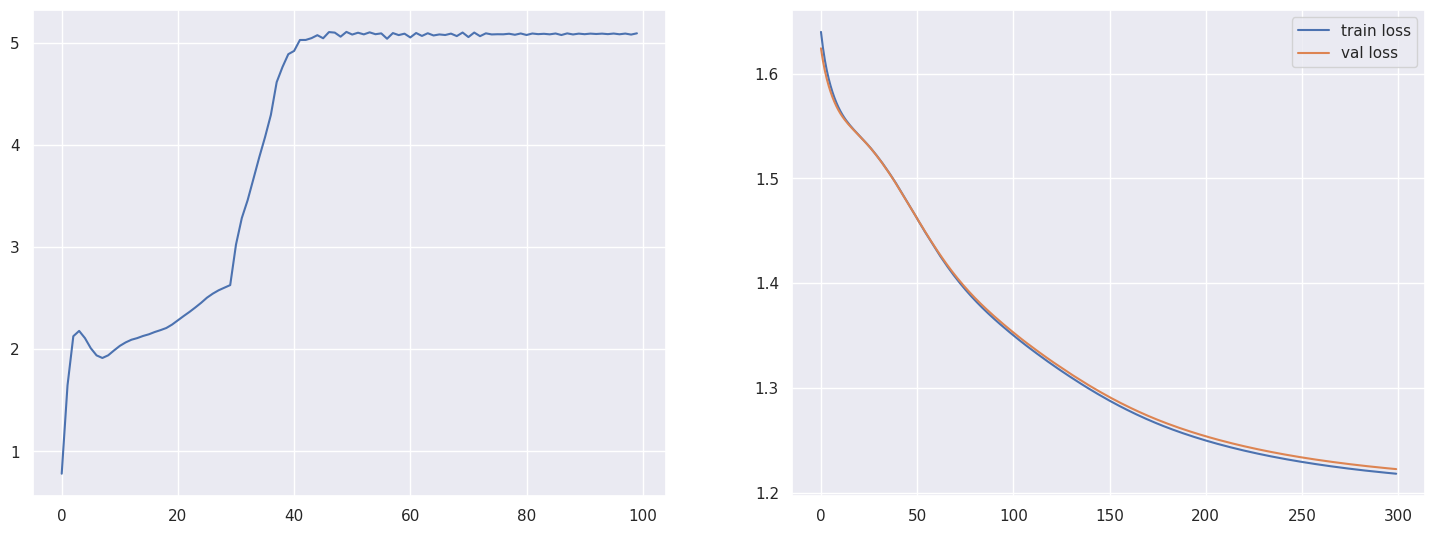

8


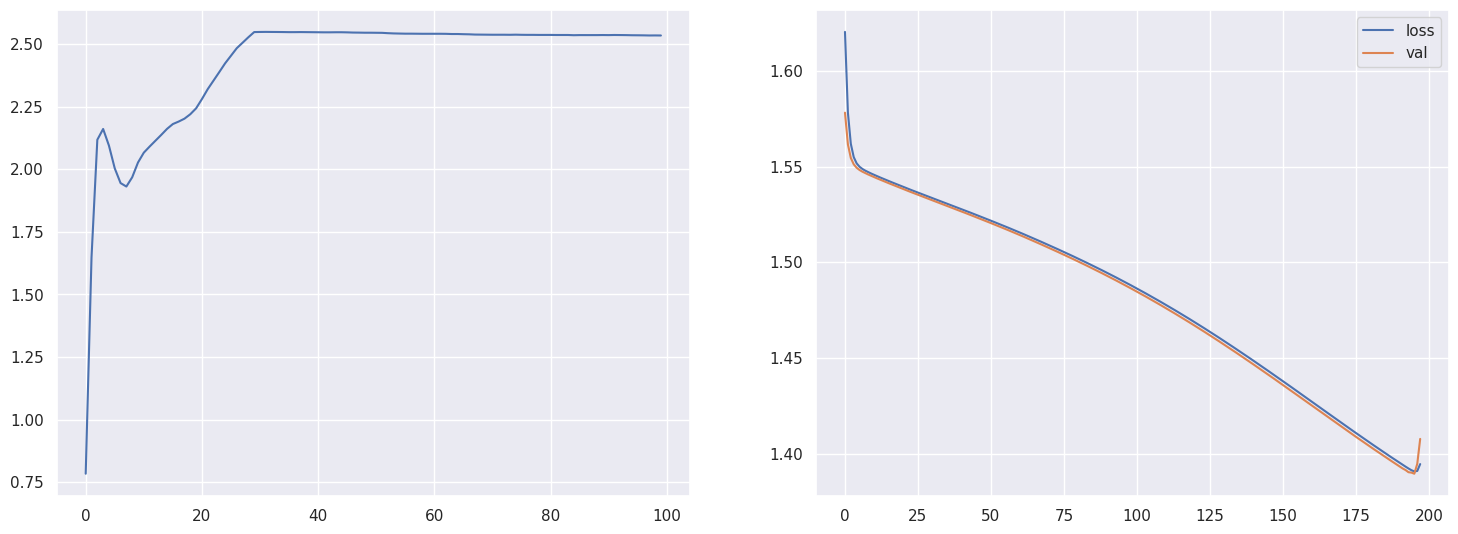

8
9
Final Training Loss: 1.279
Epoch: 193


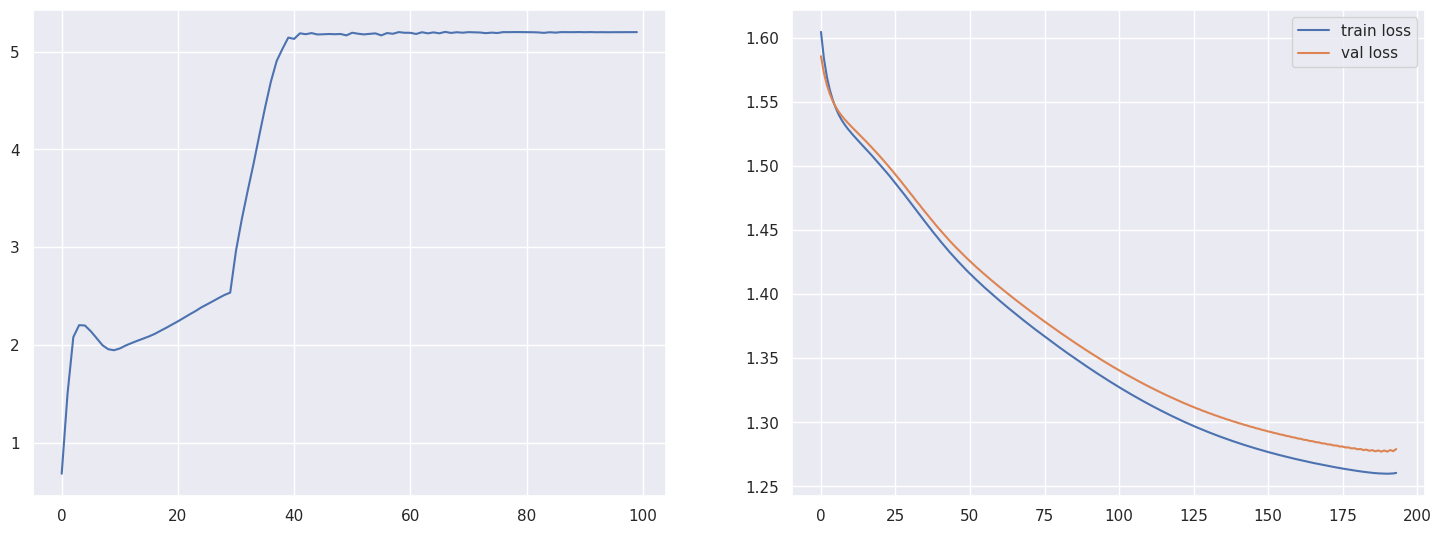

9


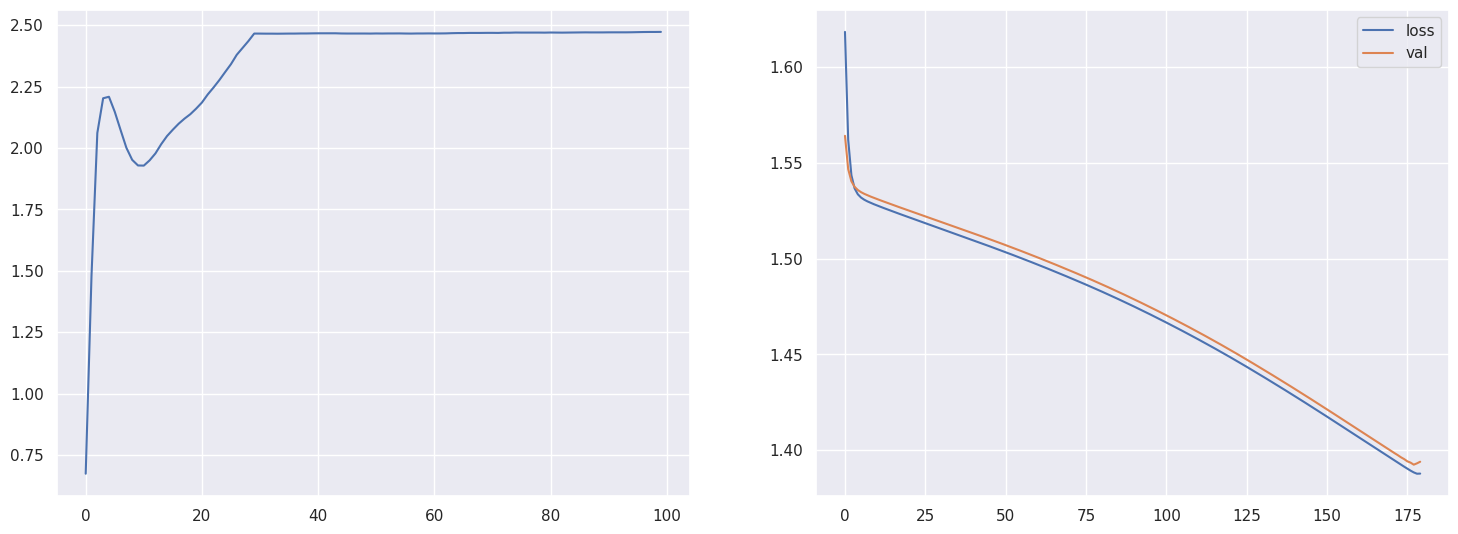

9
0.1
0
Final Training Loss: 1.210
Epoch: 271


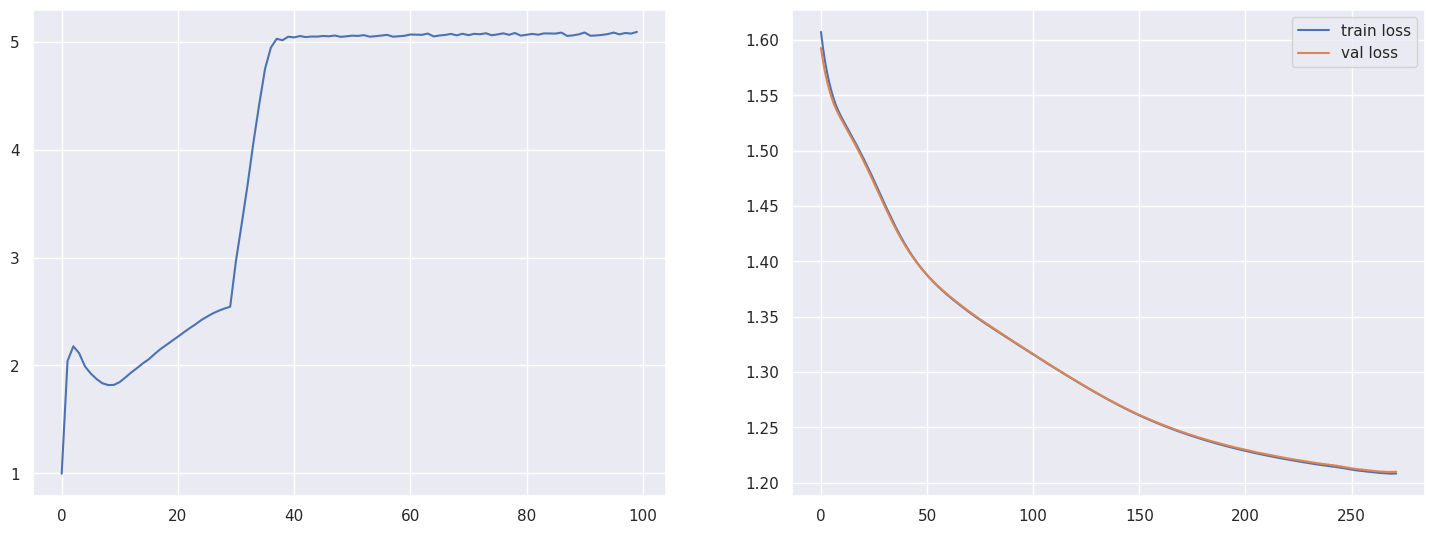

0


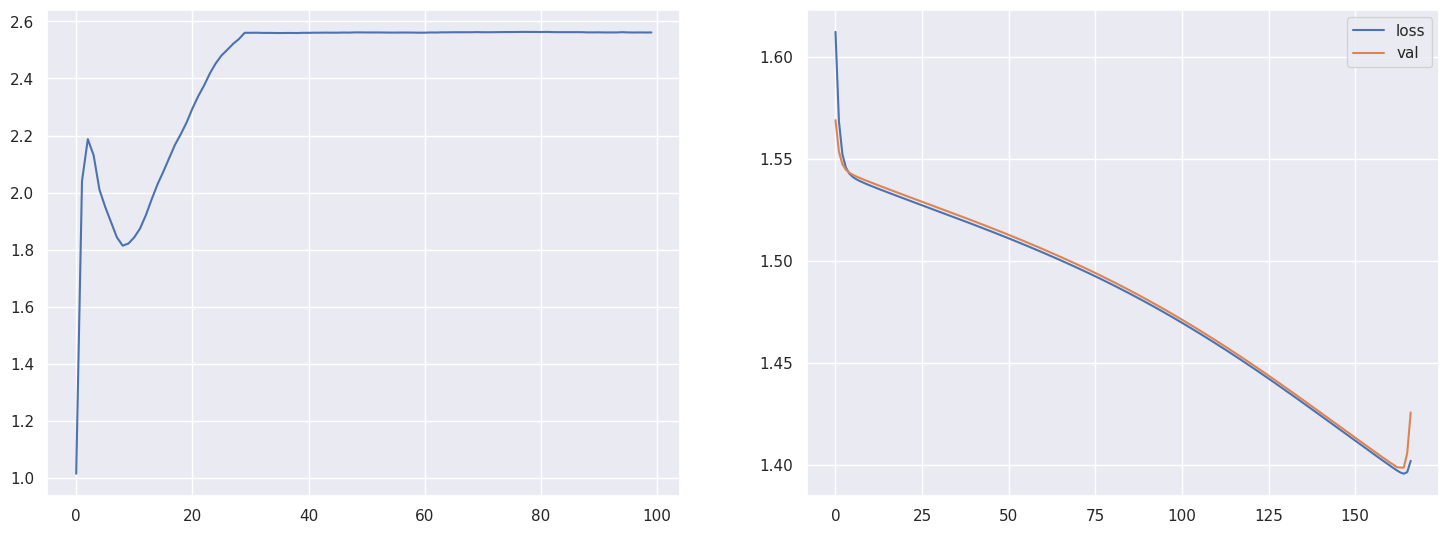

0
1
Final Training Loss: 1.243
Epoch: 299


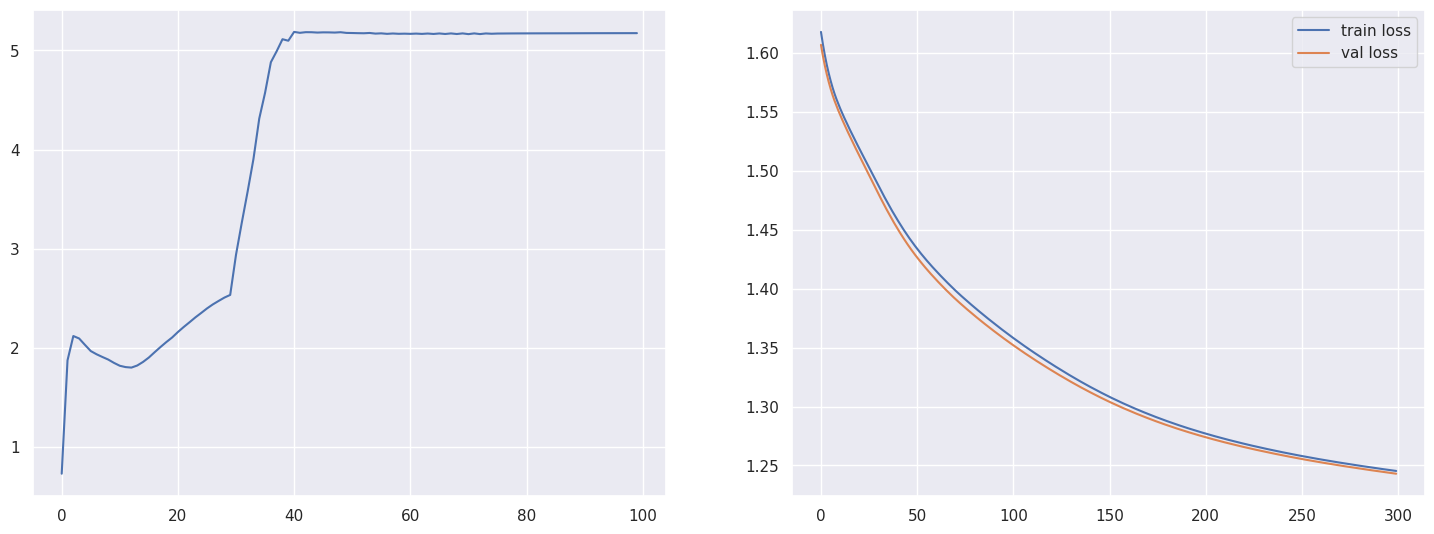

1


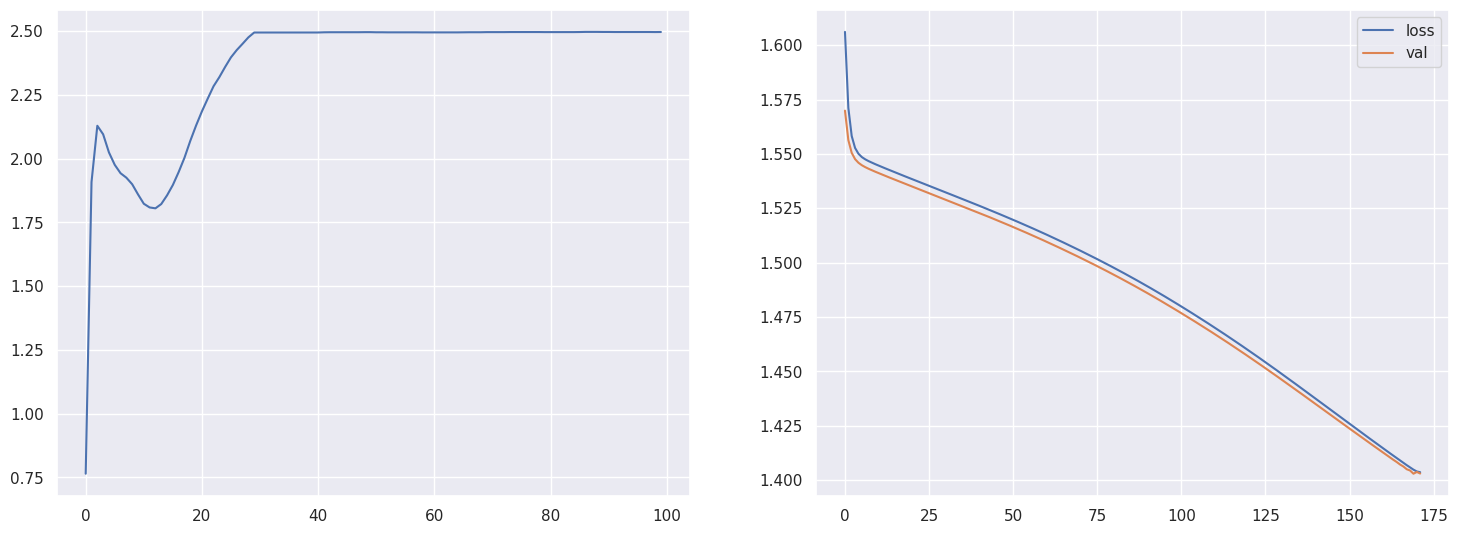

1
2
Final Training Loss: 1.231
Epoch: 299


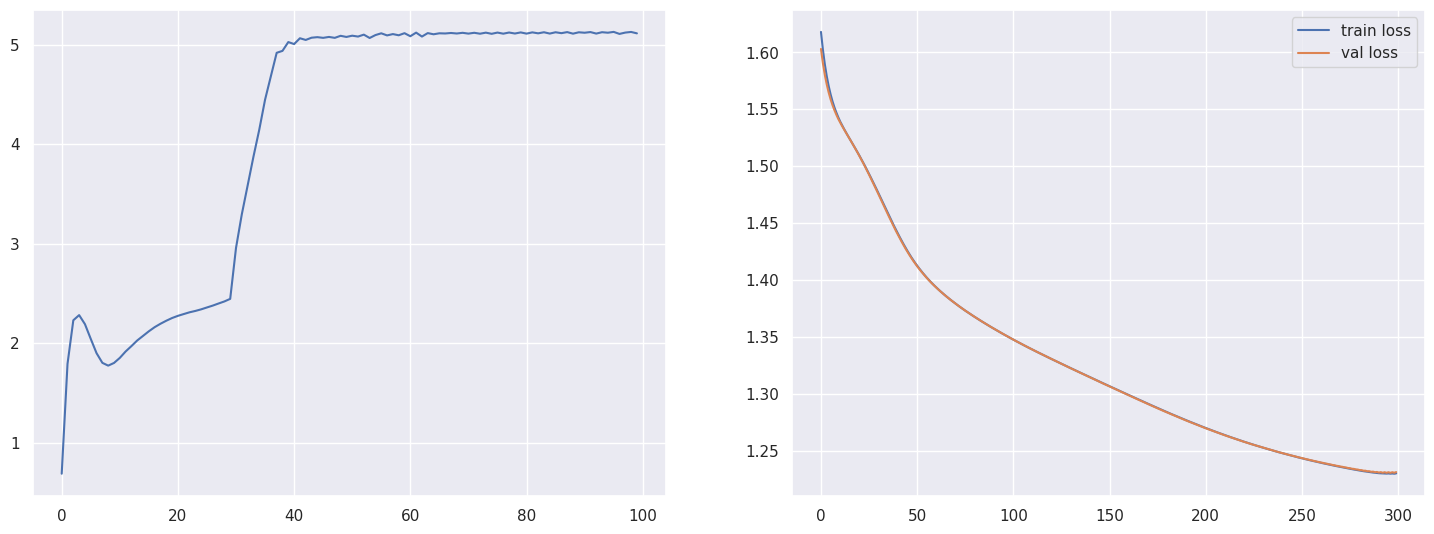

2


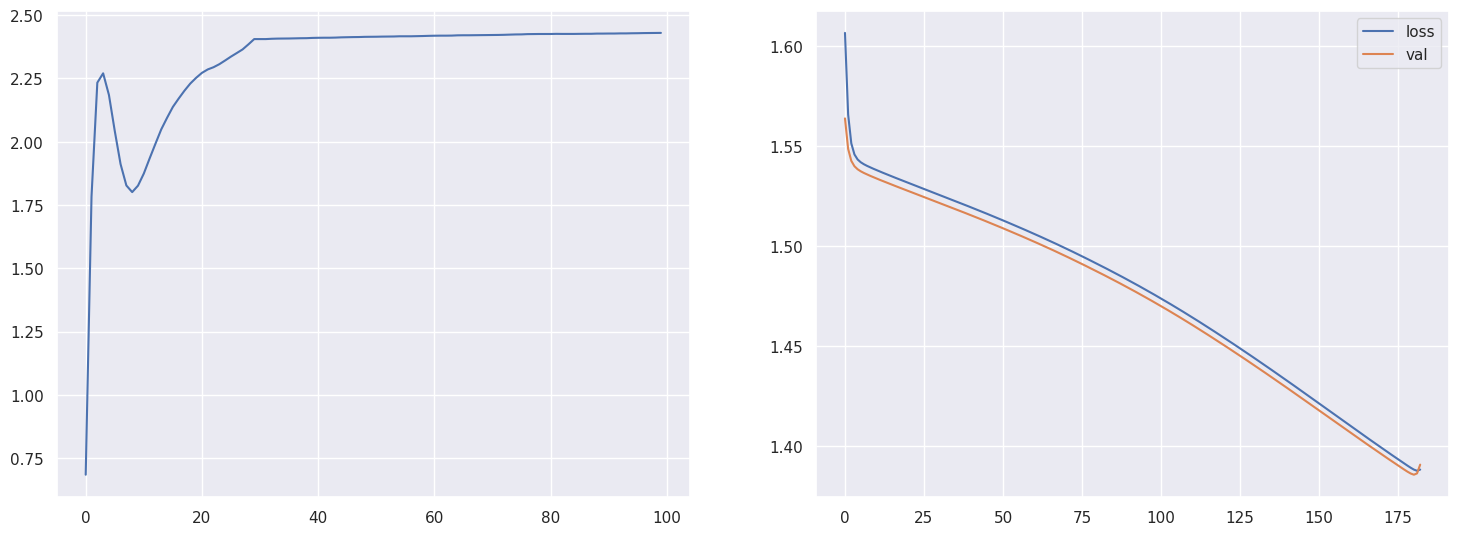

2
3
Final Training Loss: 1.196
Epoch: 289


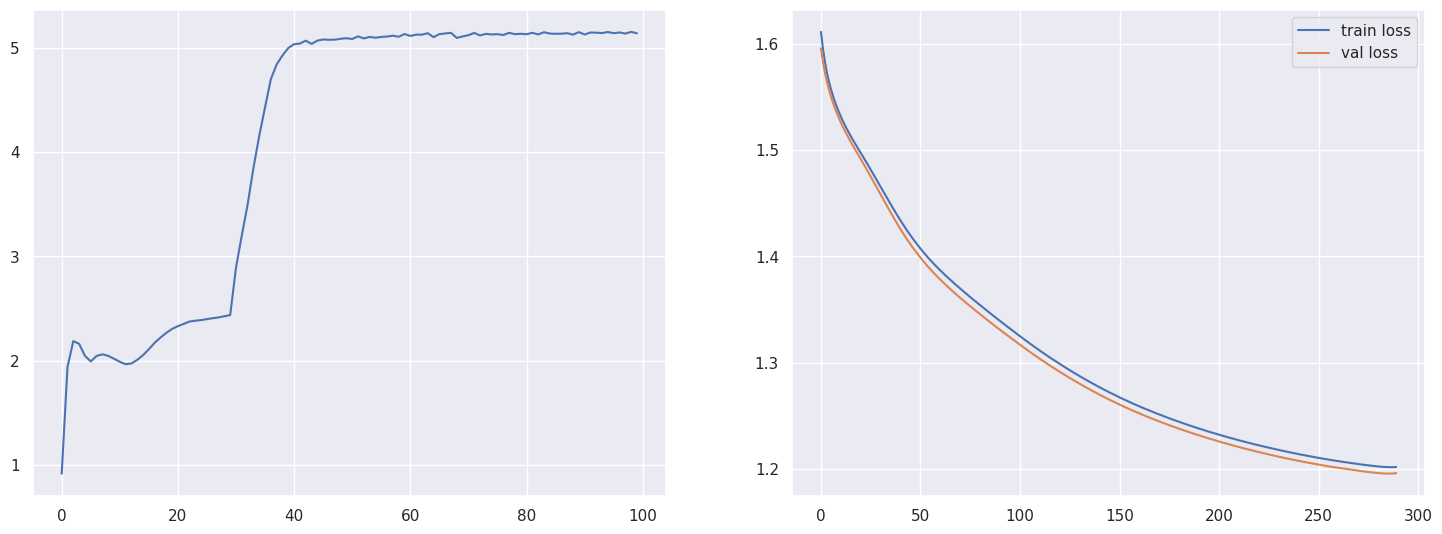

3


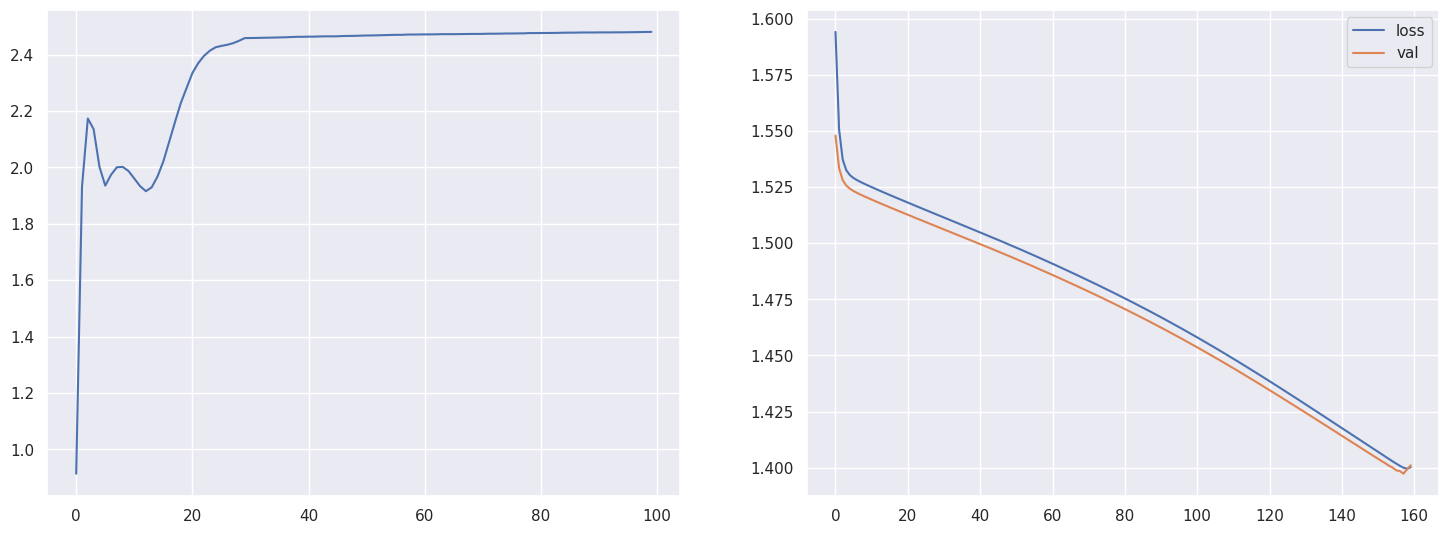

3
4
Final Training Loss: 1.260
Epoch: 209


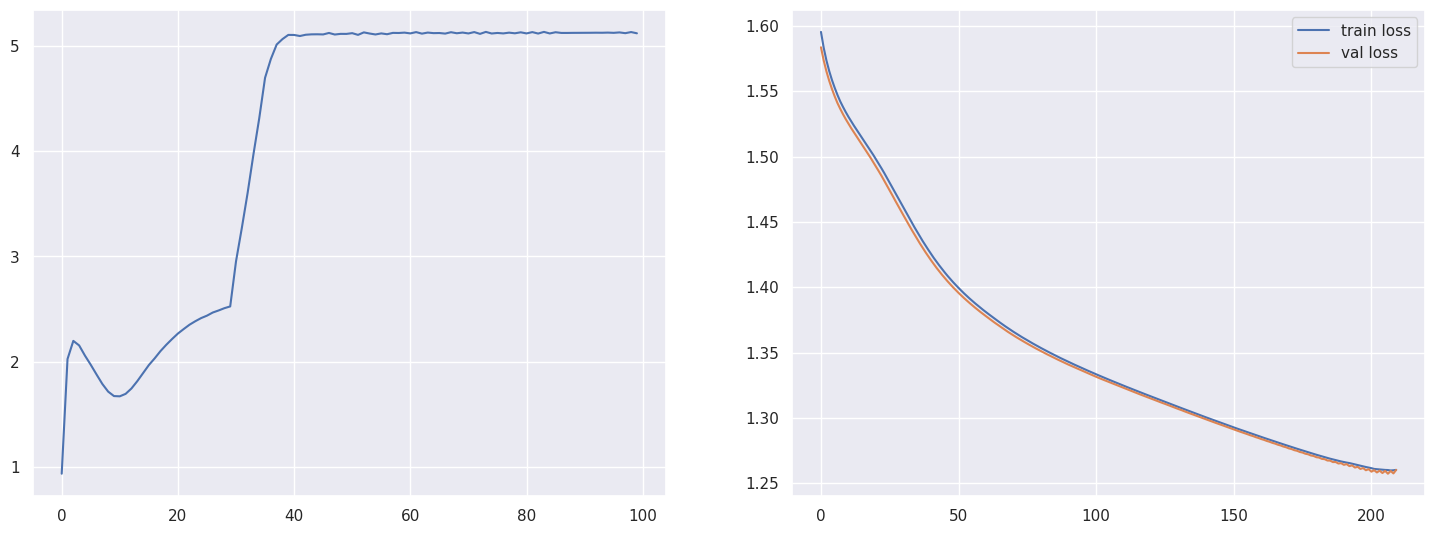

4


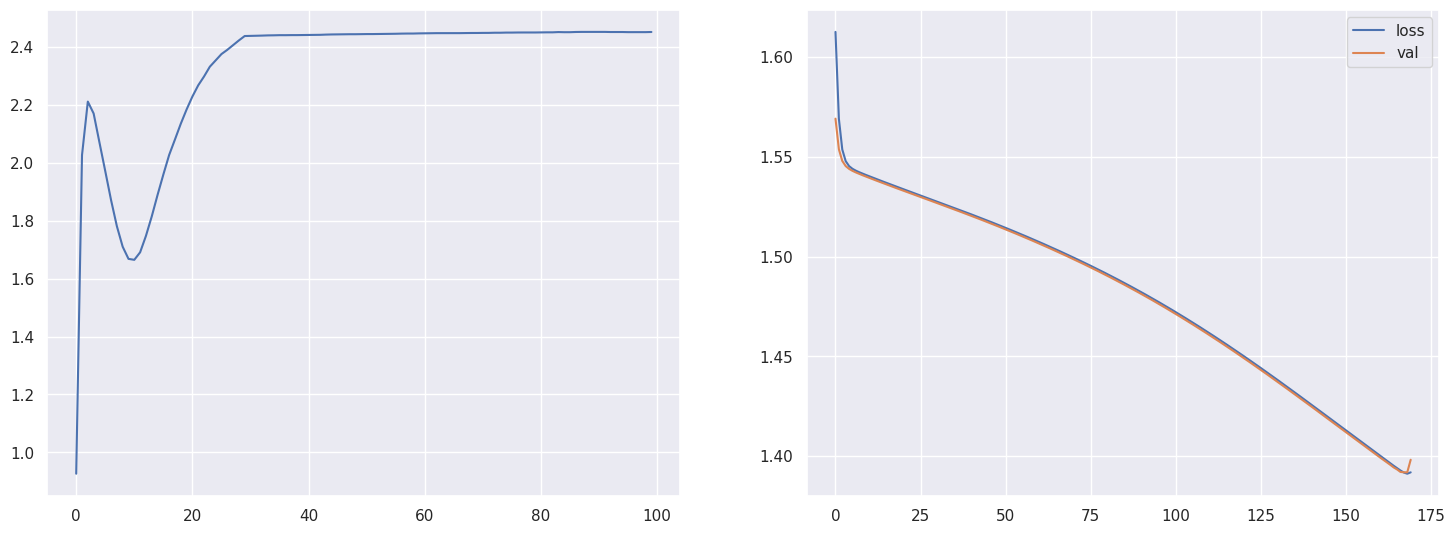

4
5
Final Training Loss: 1.243
Epoch: 299
break converge at epoch 38


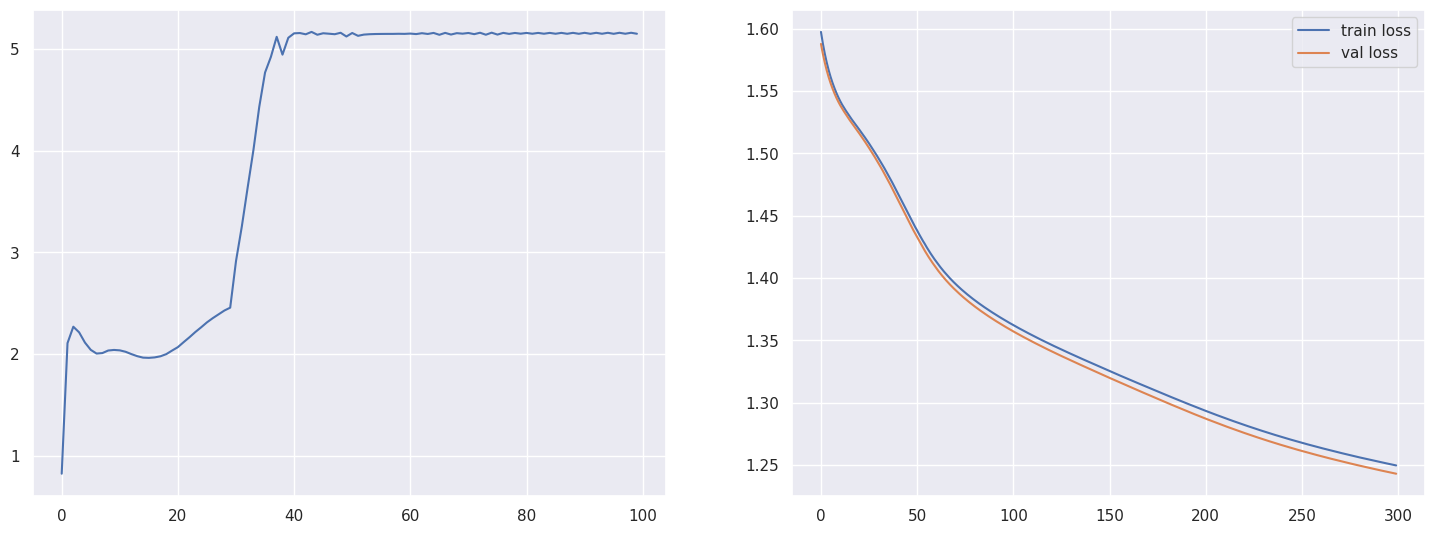

5


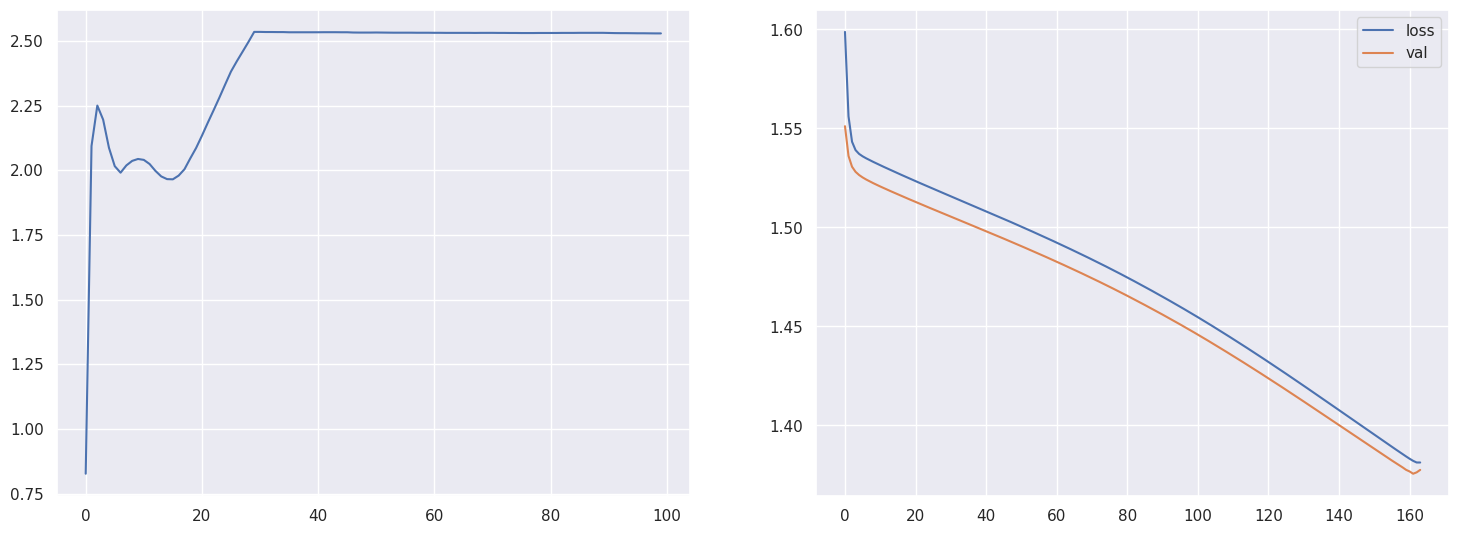

5
6
Final Training Loss: 1.222
Epoch: 299


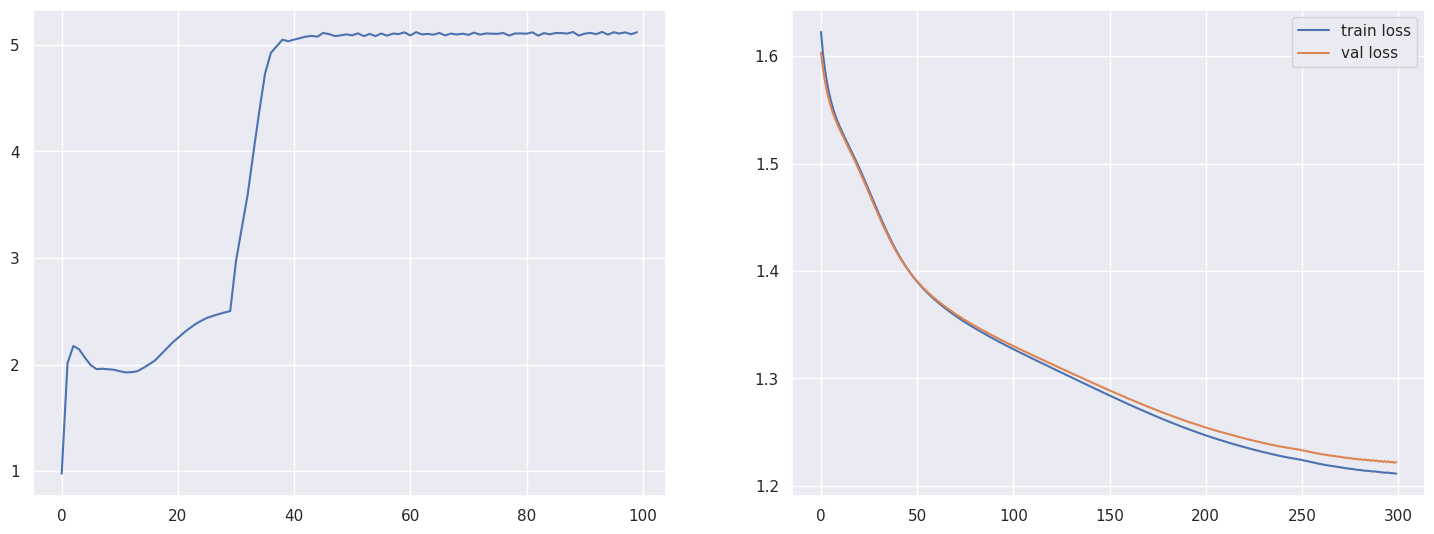

6


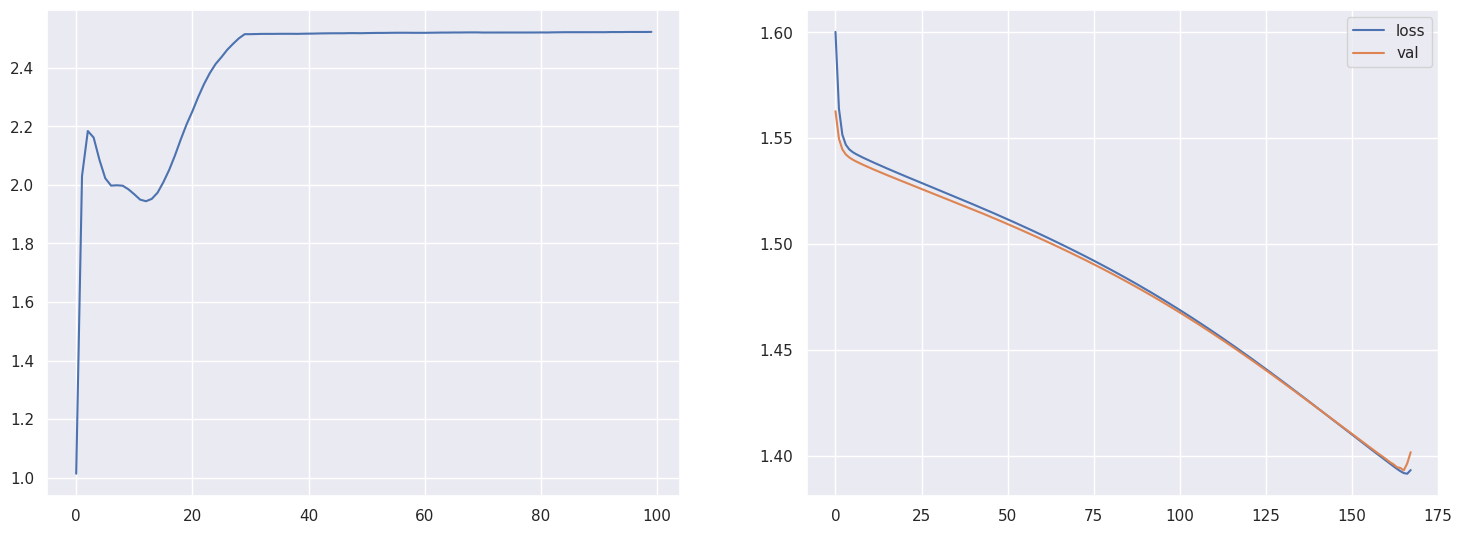

6
7
Final Training Loss: 1.228
Epoch: 191


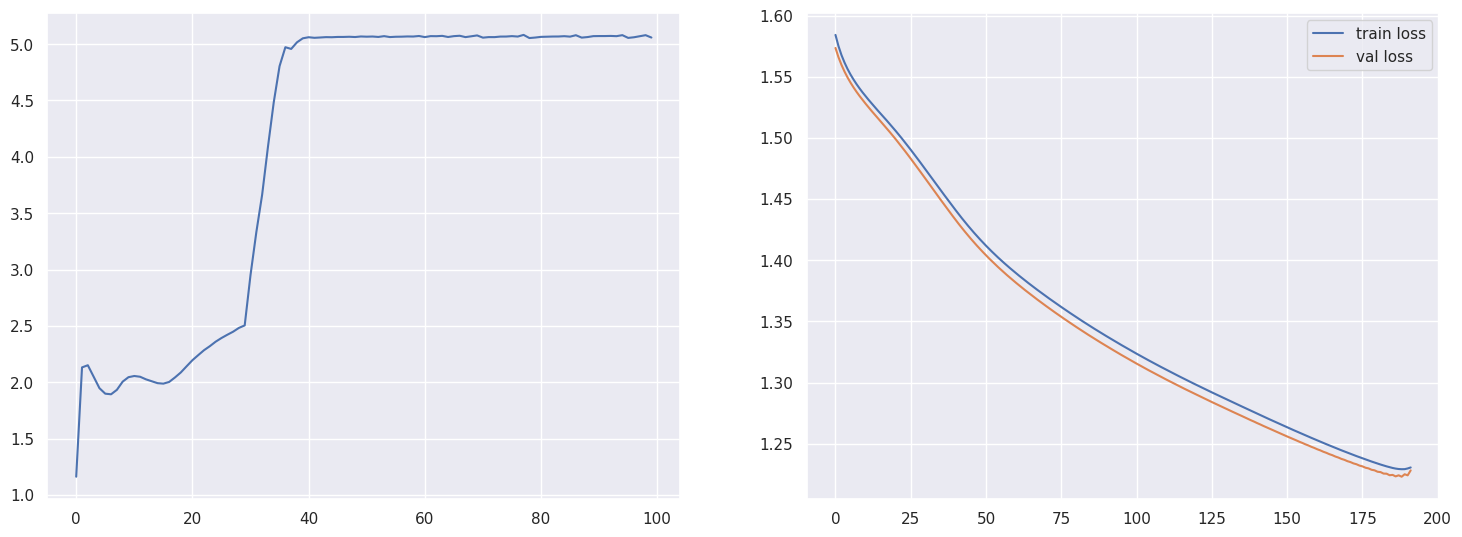

7


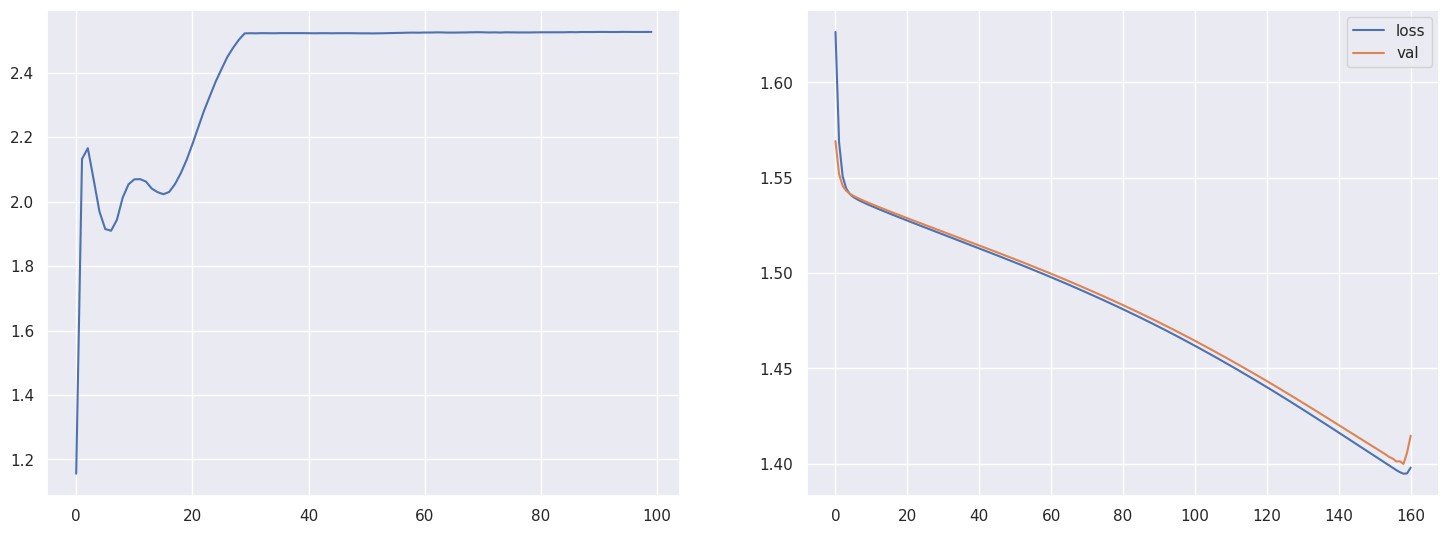

7
8
Final Training Loss: 1.238
Epoch: 299


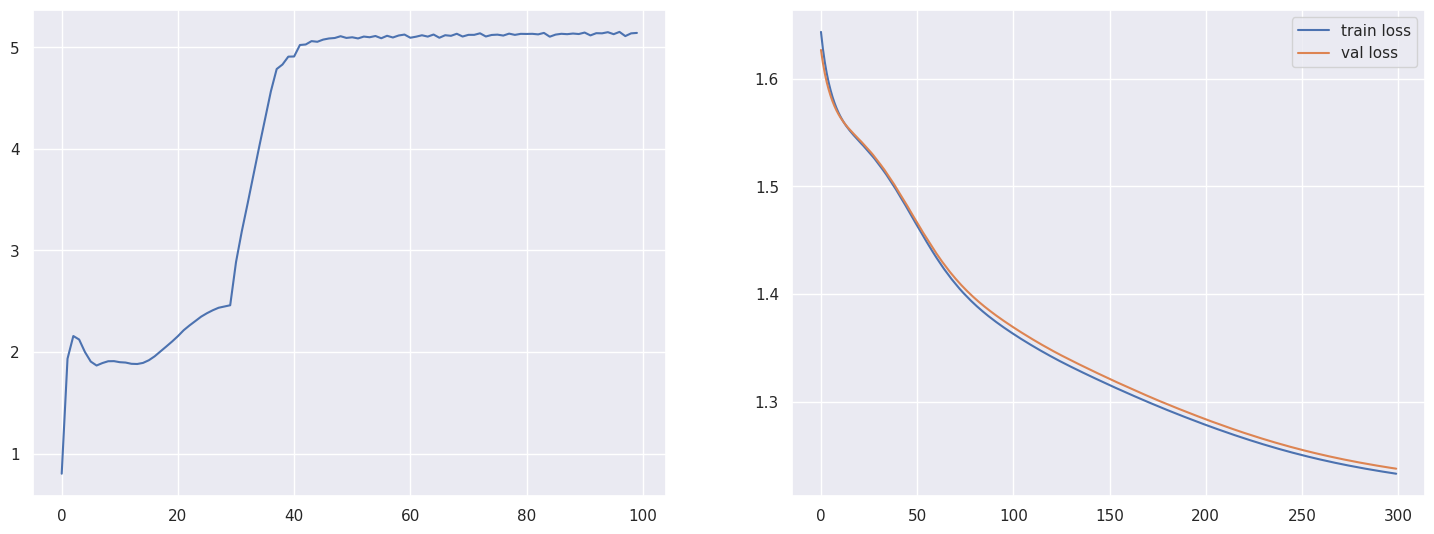

8


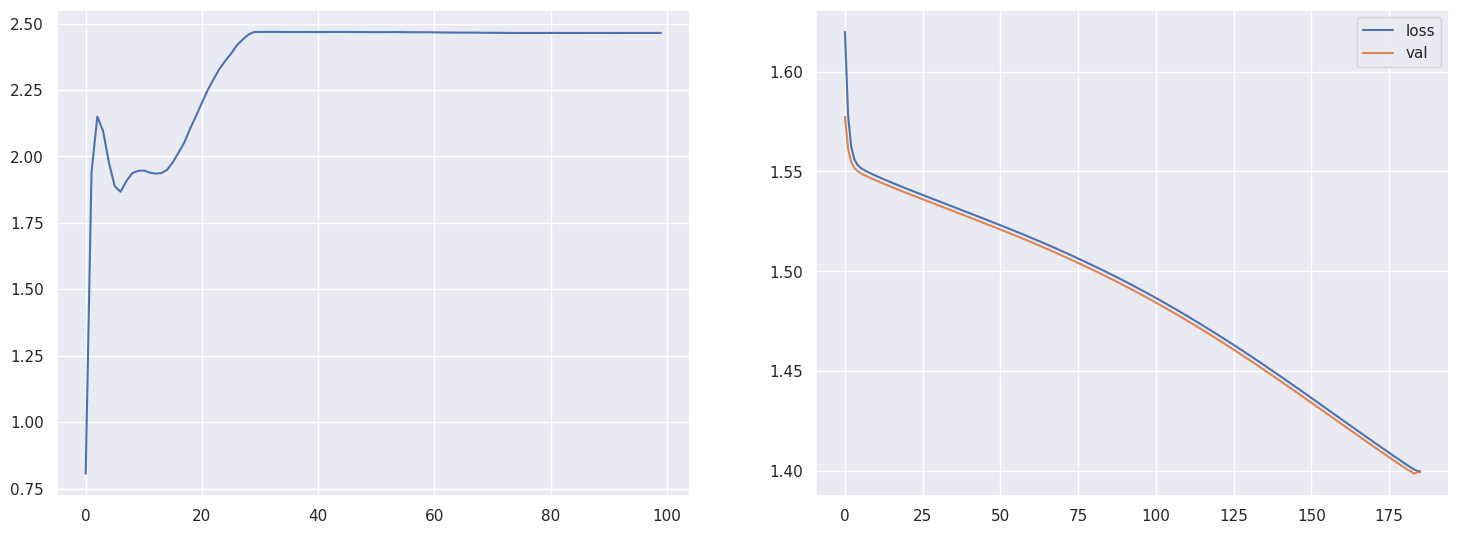

8
9
Final Training Loss: 1.291
Epoch: 203


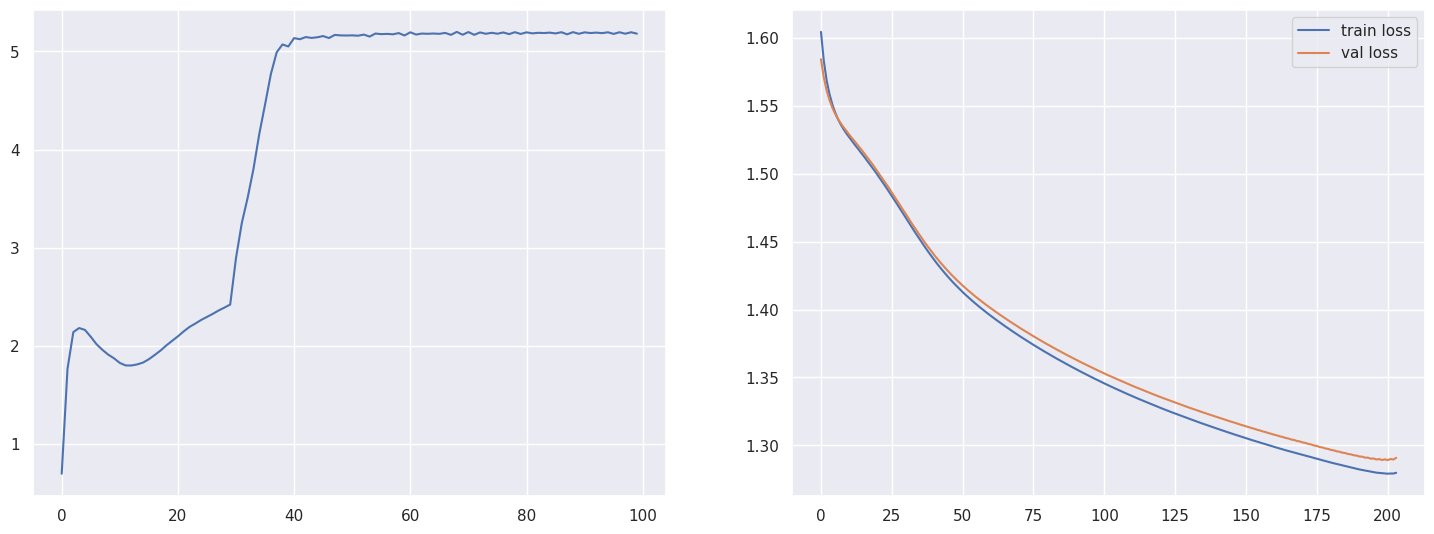

9


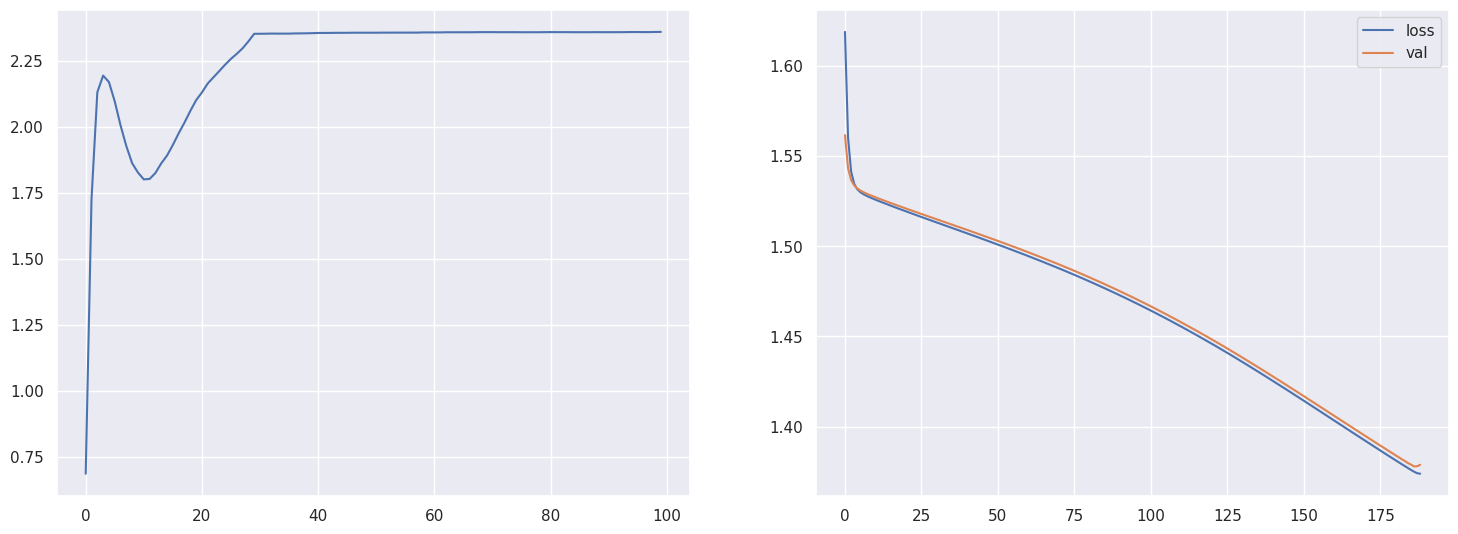

9
0.05
0
Final Training Loss: 1.285
Epoch: 299


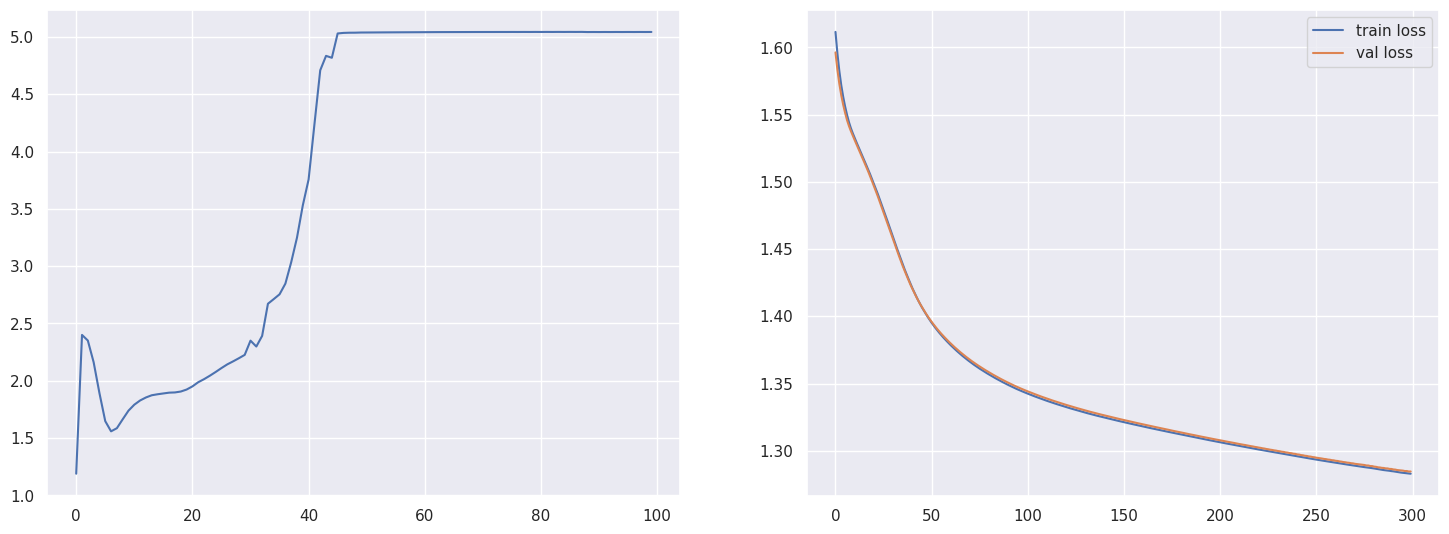

0


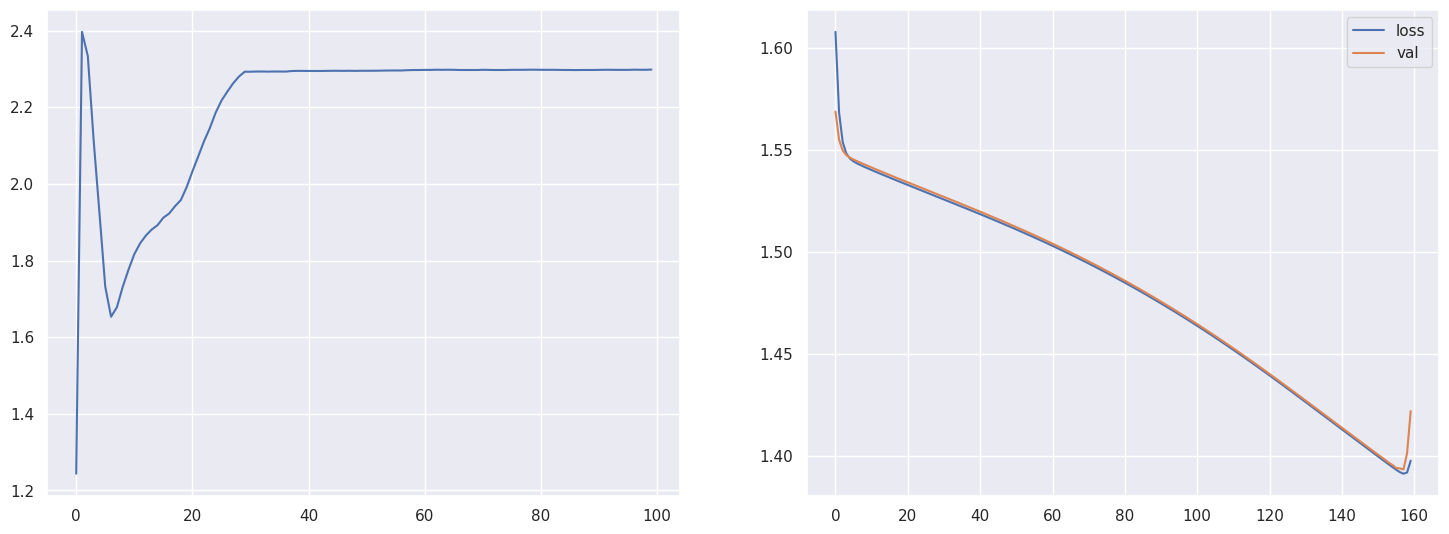

0
1
Final Training Loss: 1.317
Epoch: 299
break converge at epoch 39


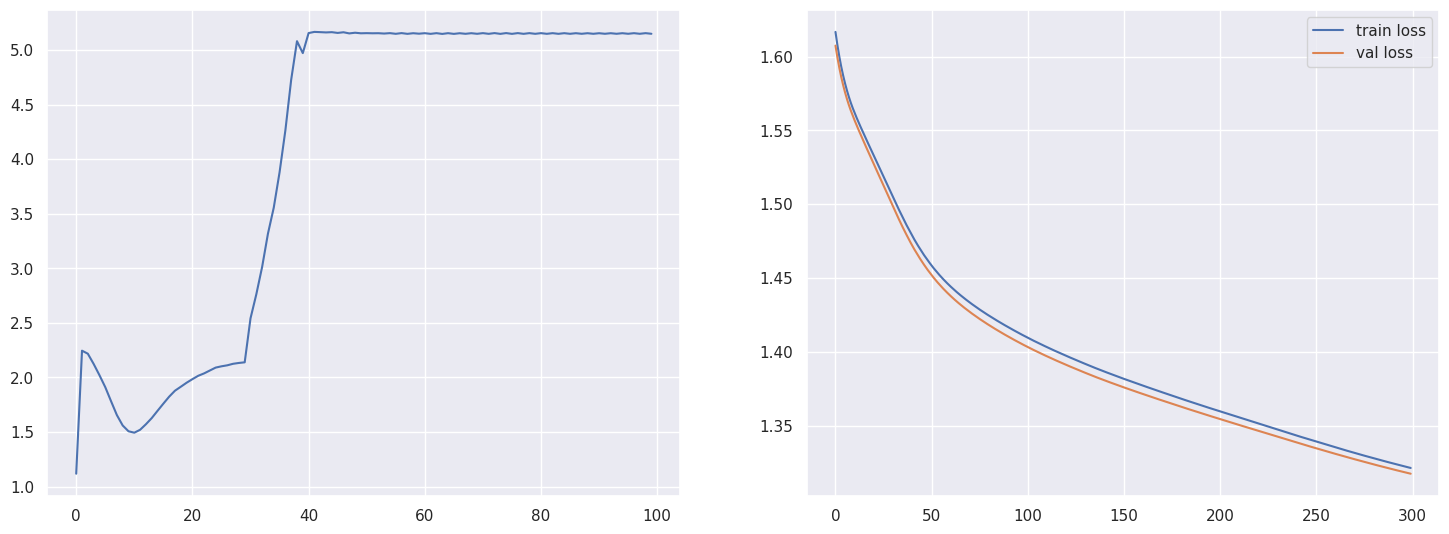

1


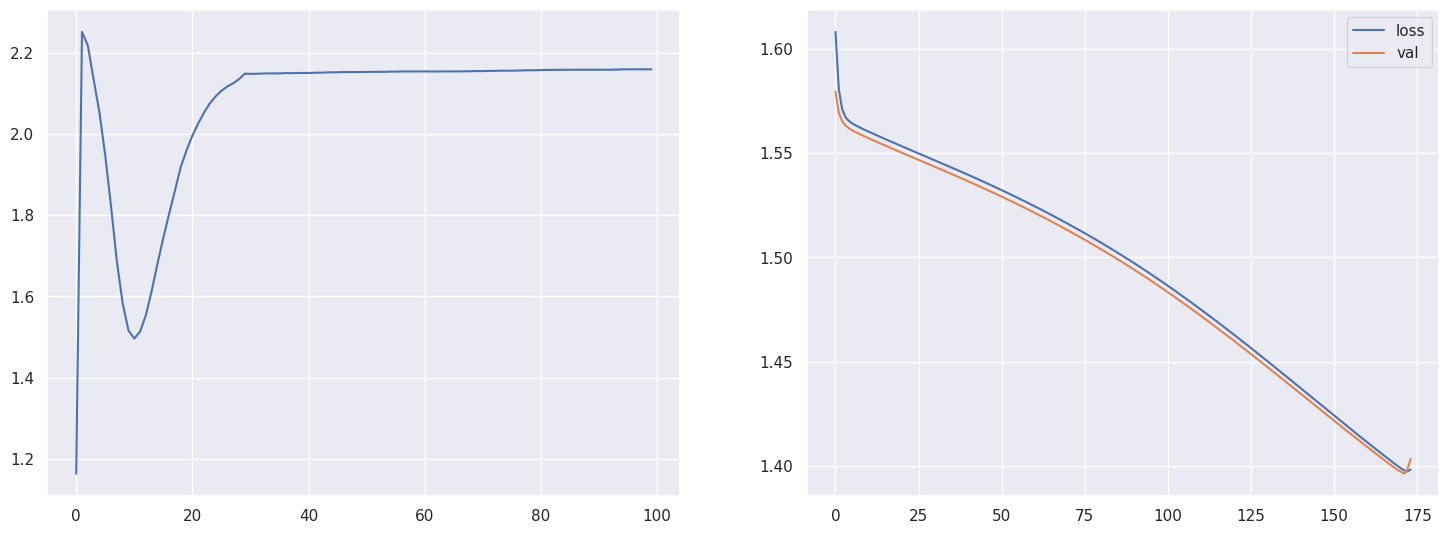

1
2
Final Training Loss: 1.313
Epoch: 299


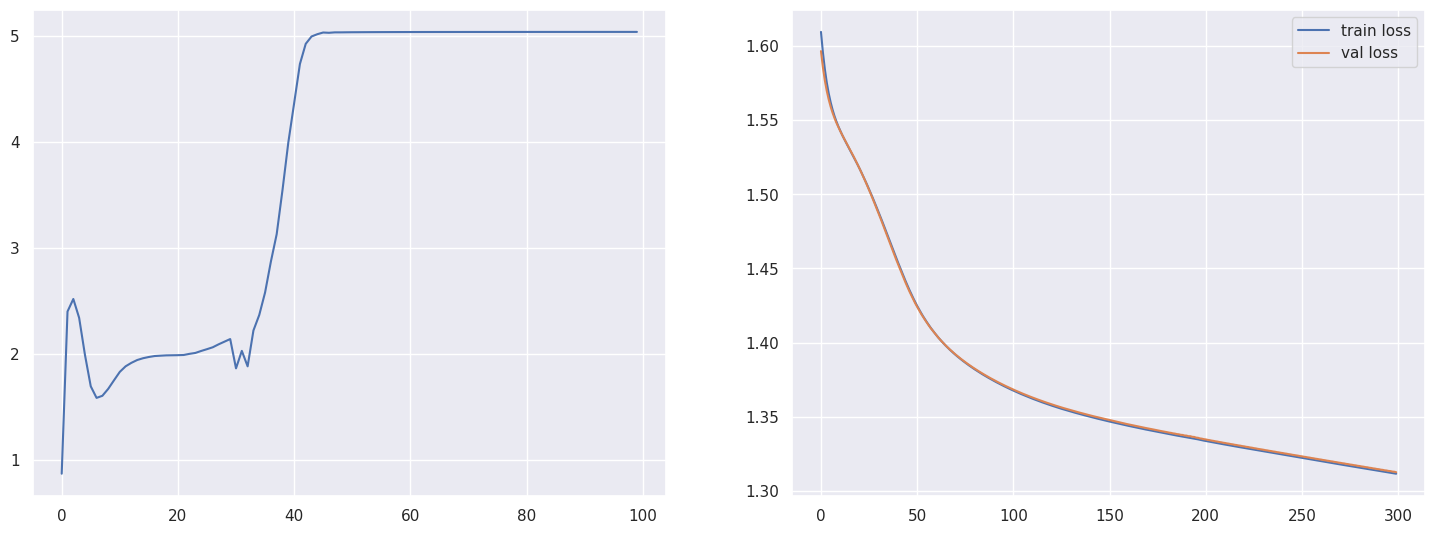

2


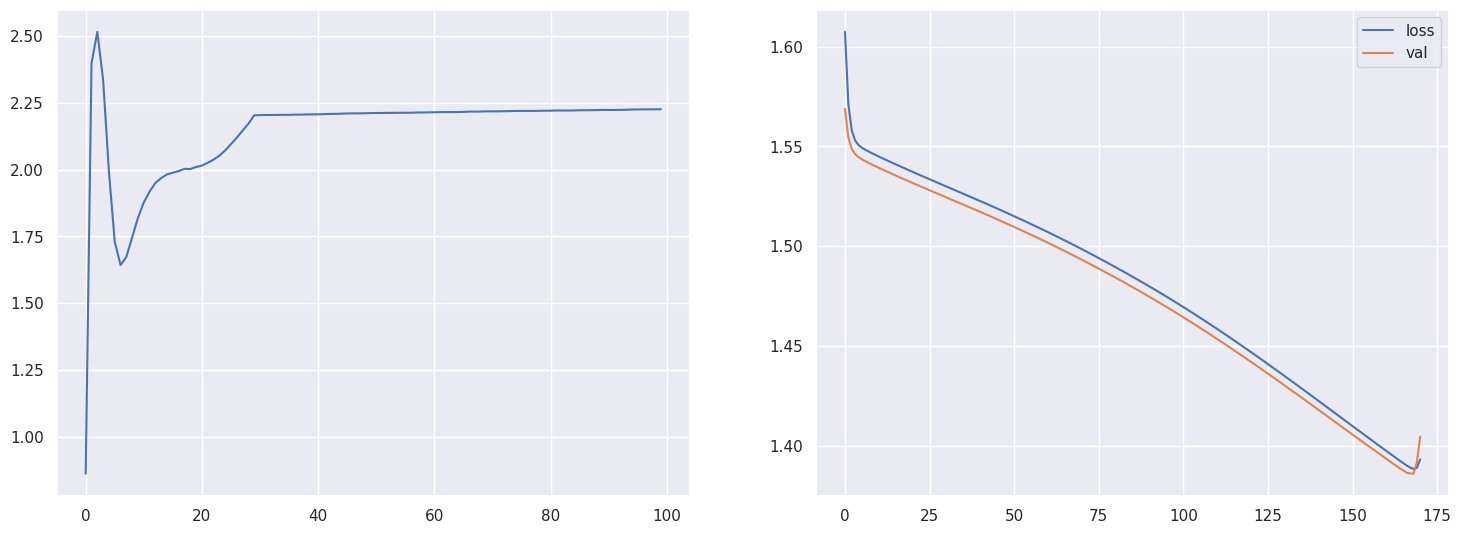

2
3
Final Training Loss: 1.237
Epoch: 299


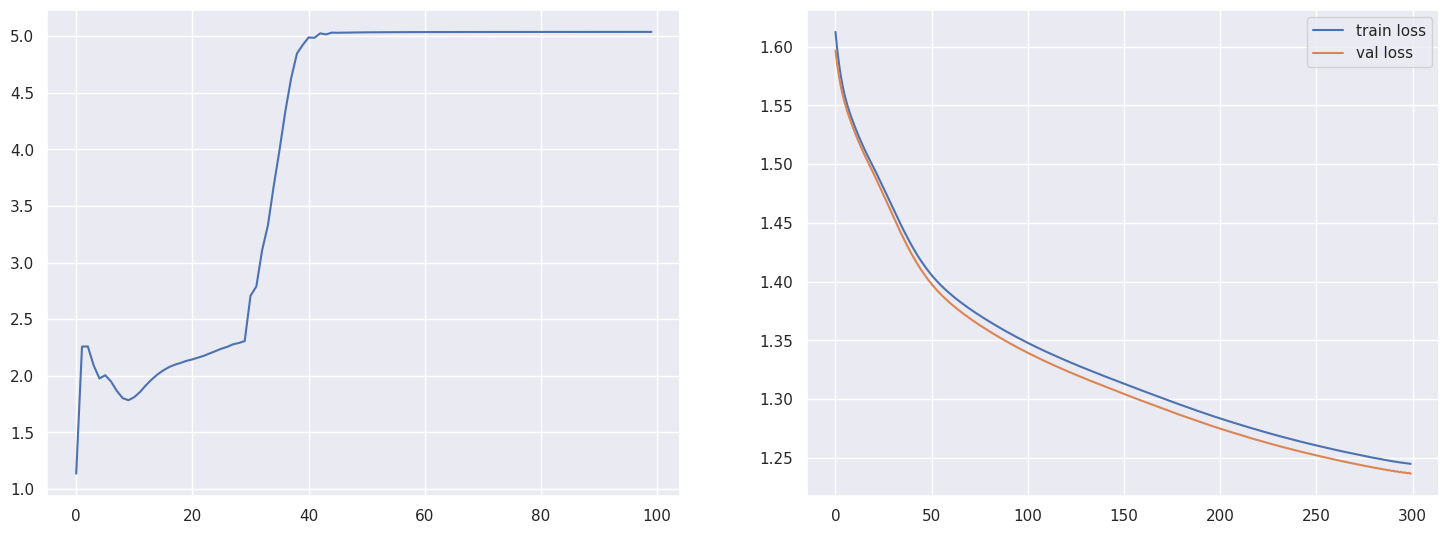

3


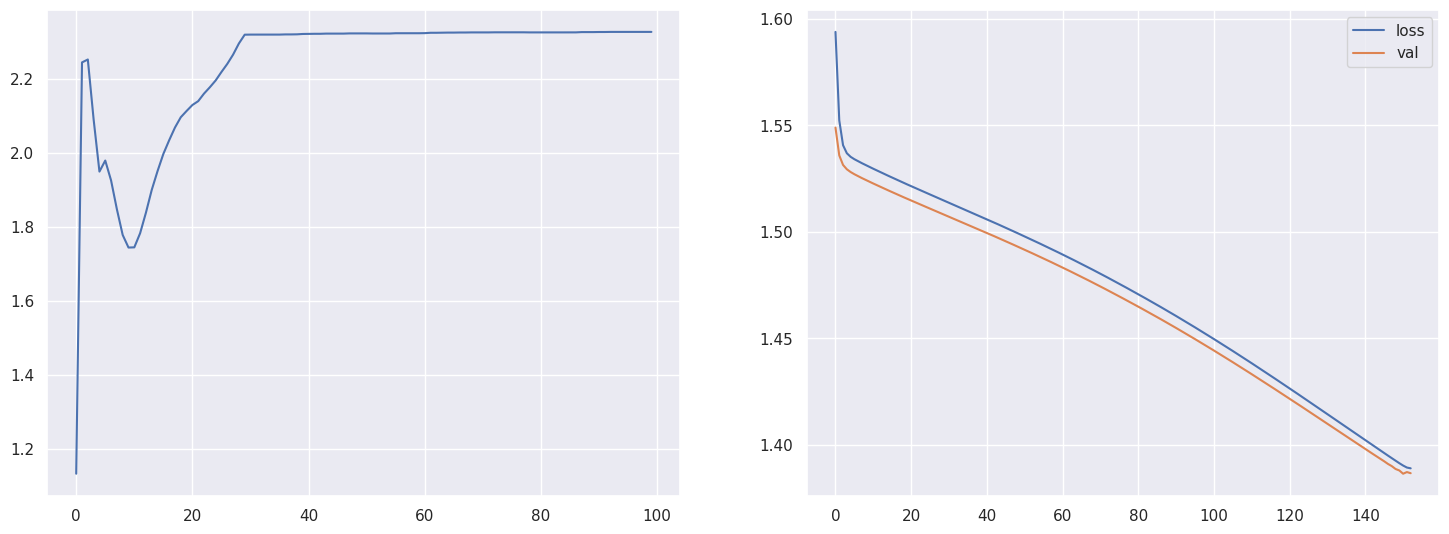

3
4
Final Training Loss: 1.305
Epoch: 240


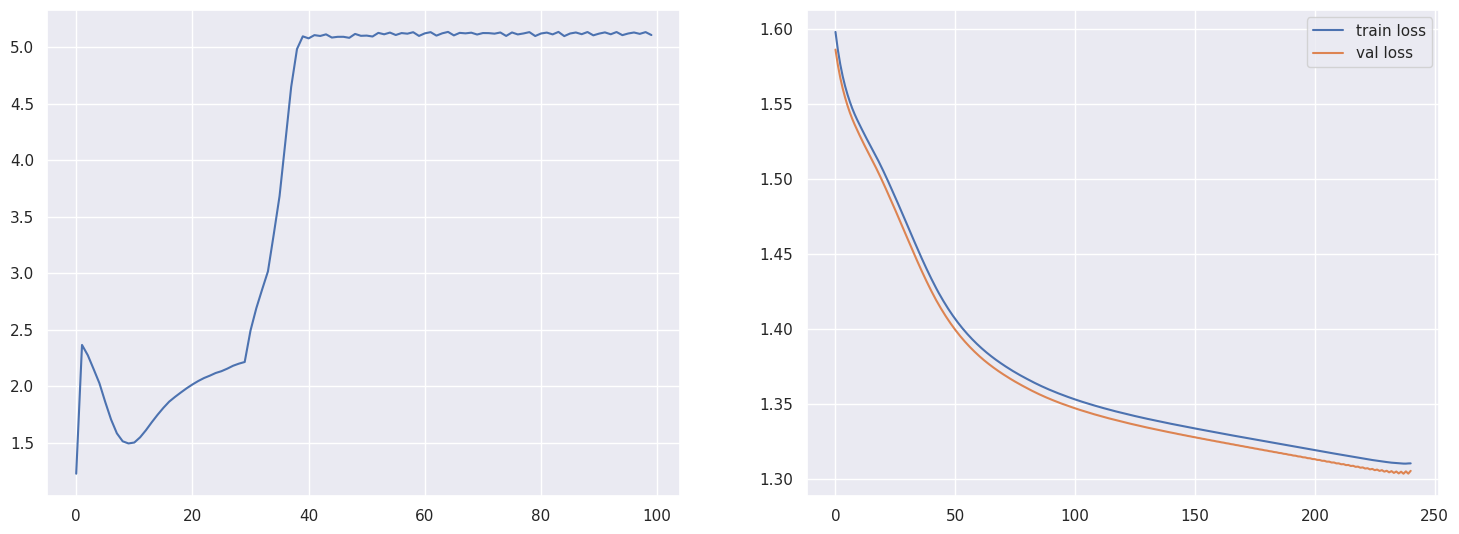

4


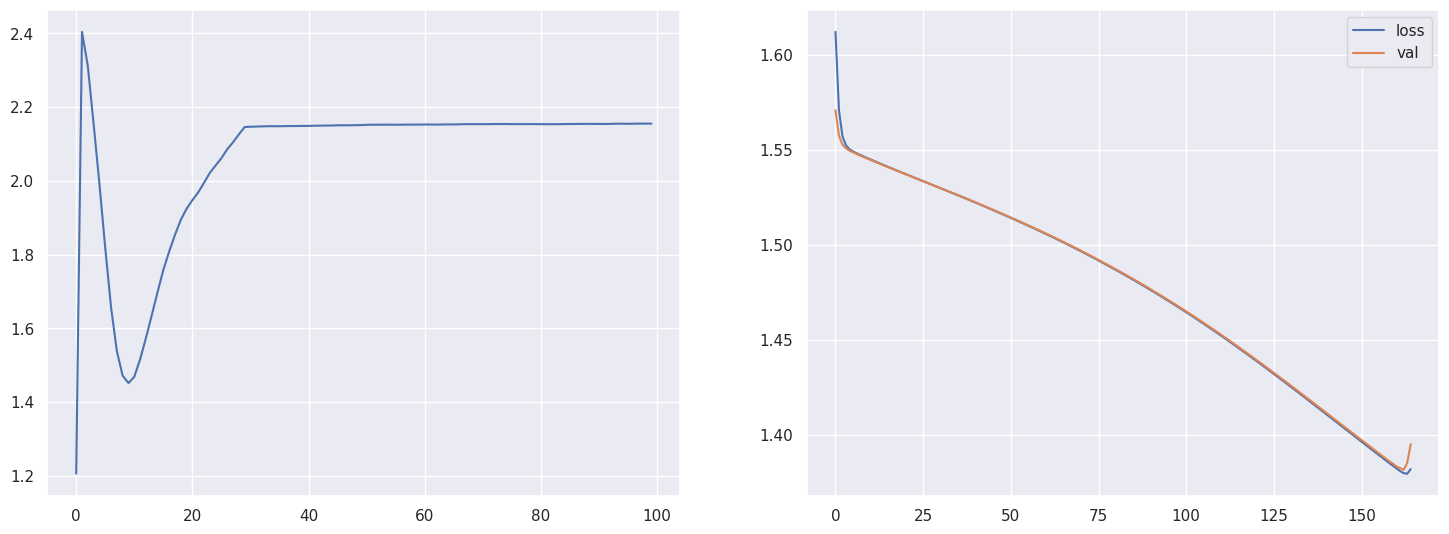

4
5
Final Training Loss: 1.267
Epoch: 299


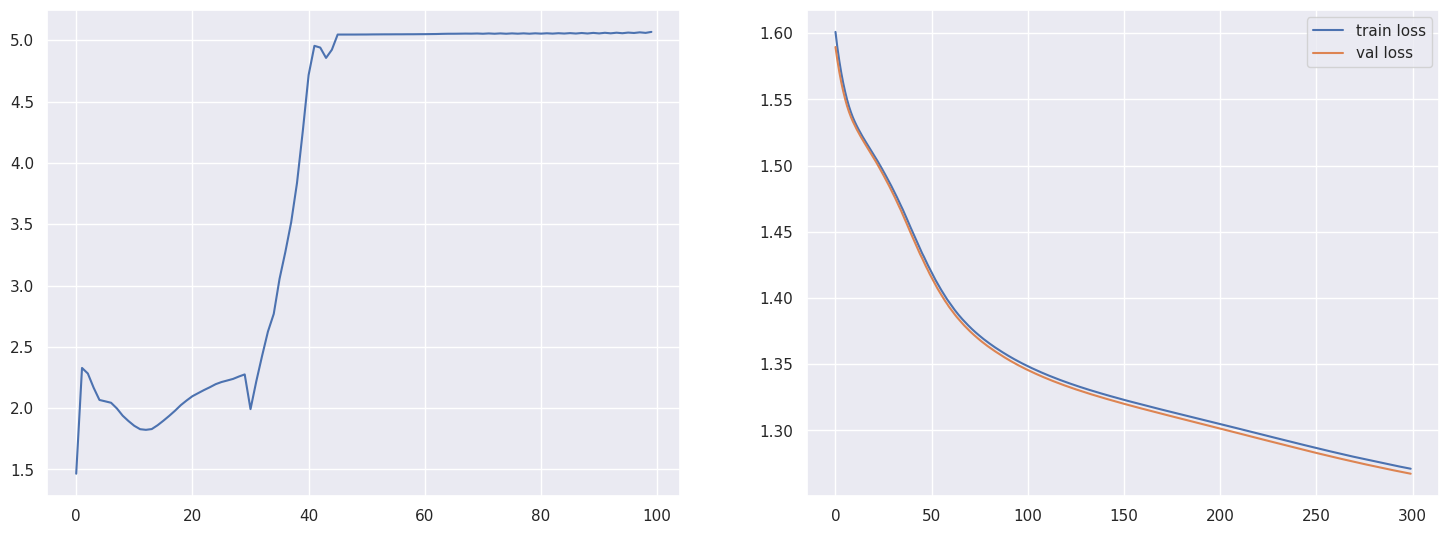

5


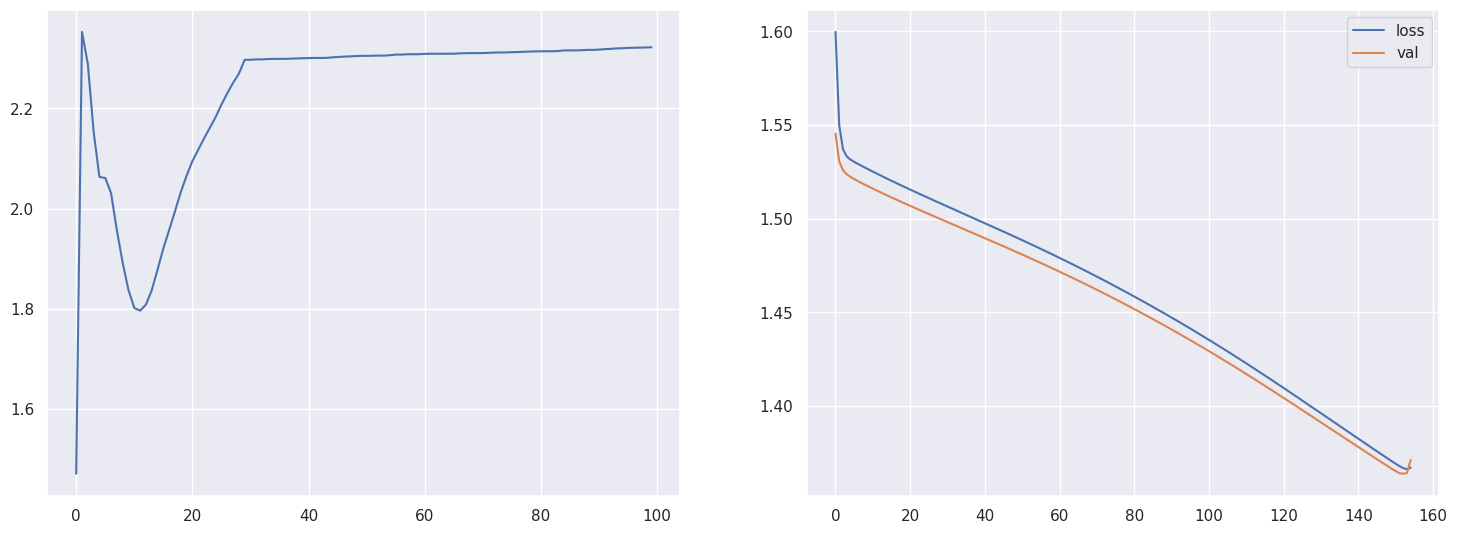

5
6
Final Training Loss: 1.265
Epoch: 299


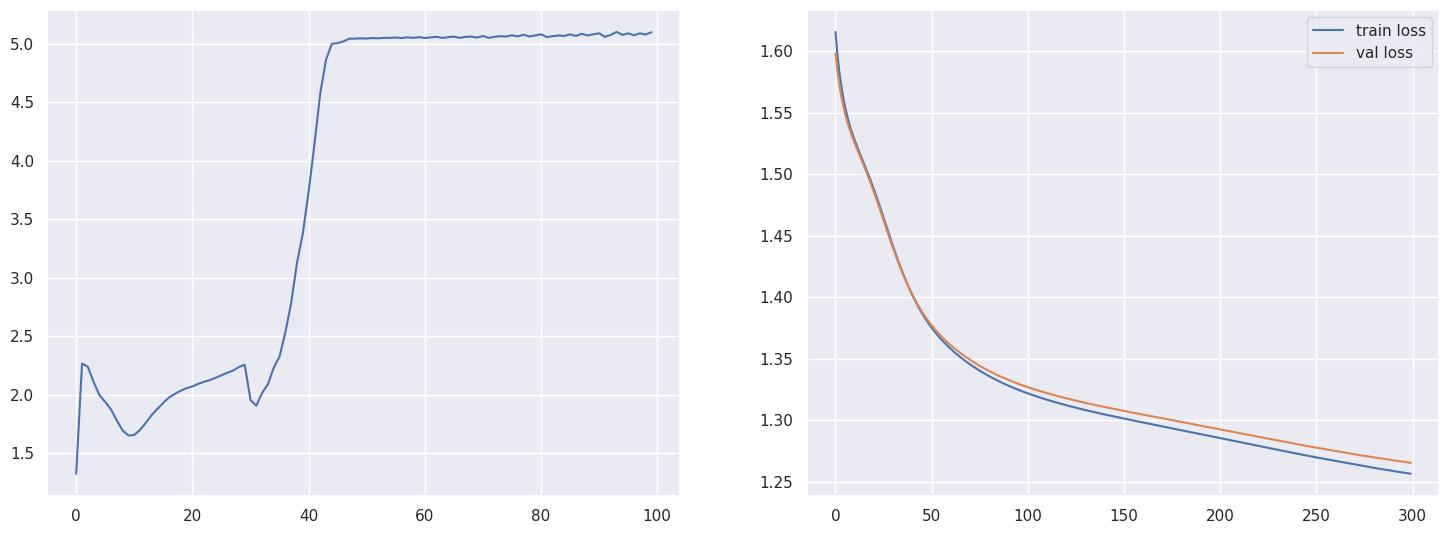

6


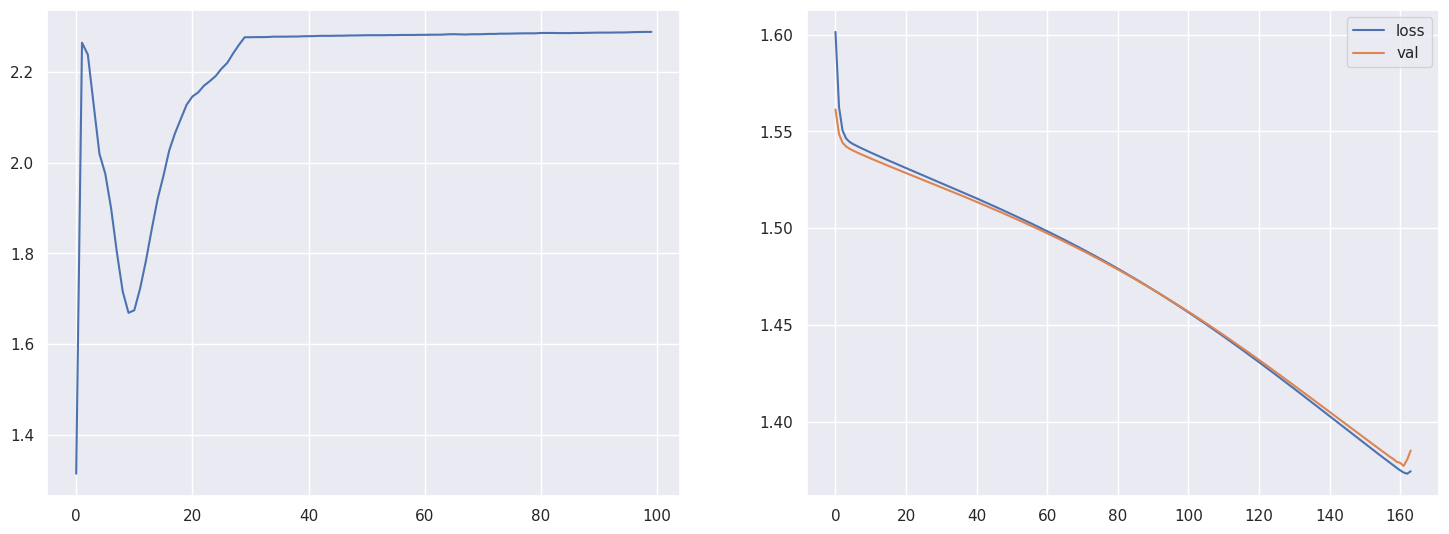

6
7
Final Training Loss: 1.250
Epoch: 196


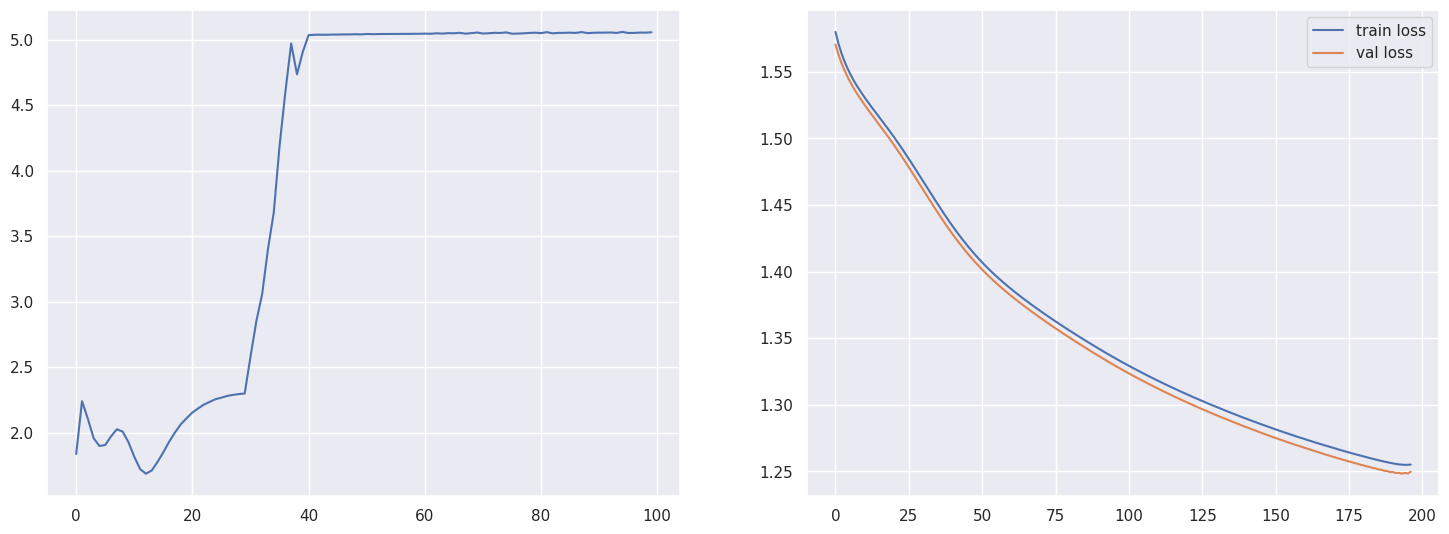

7


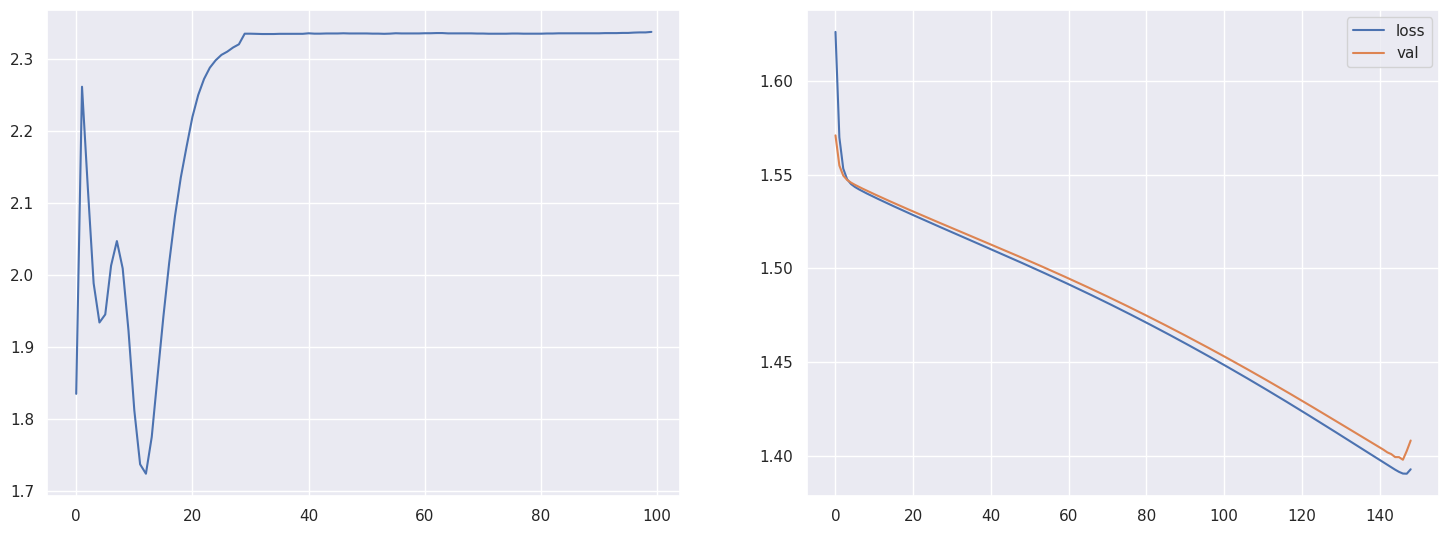

7
8
Final Training Loss: 1.287
Epoch: 299
break converge at epoch 44


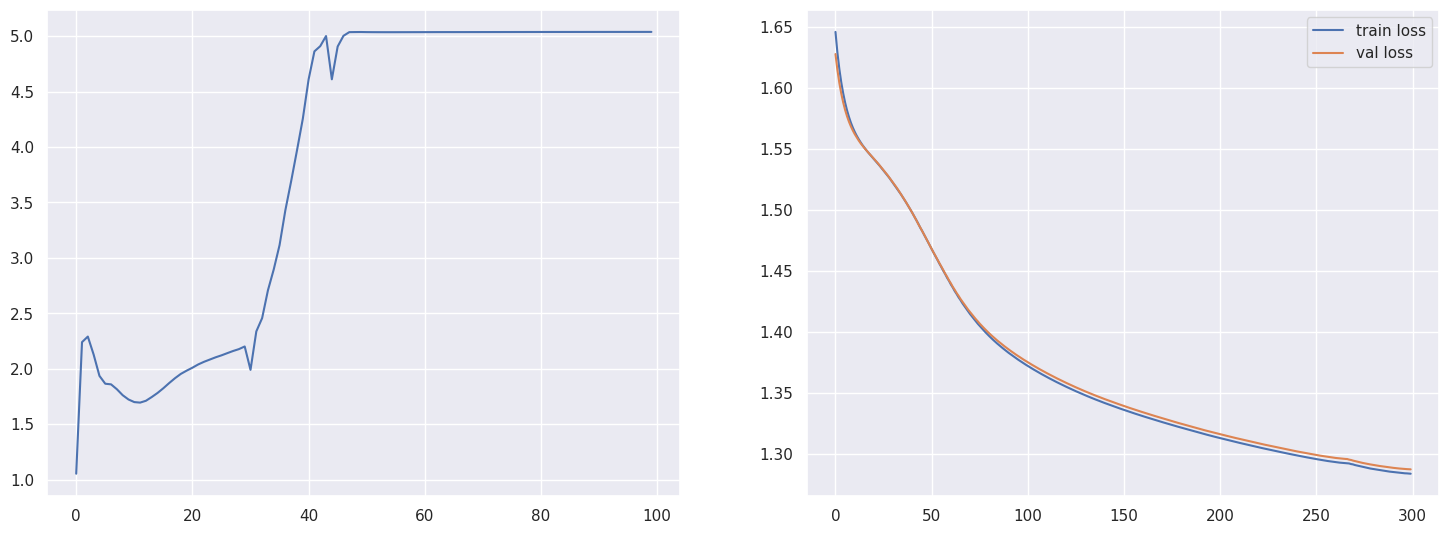

8


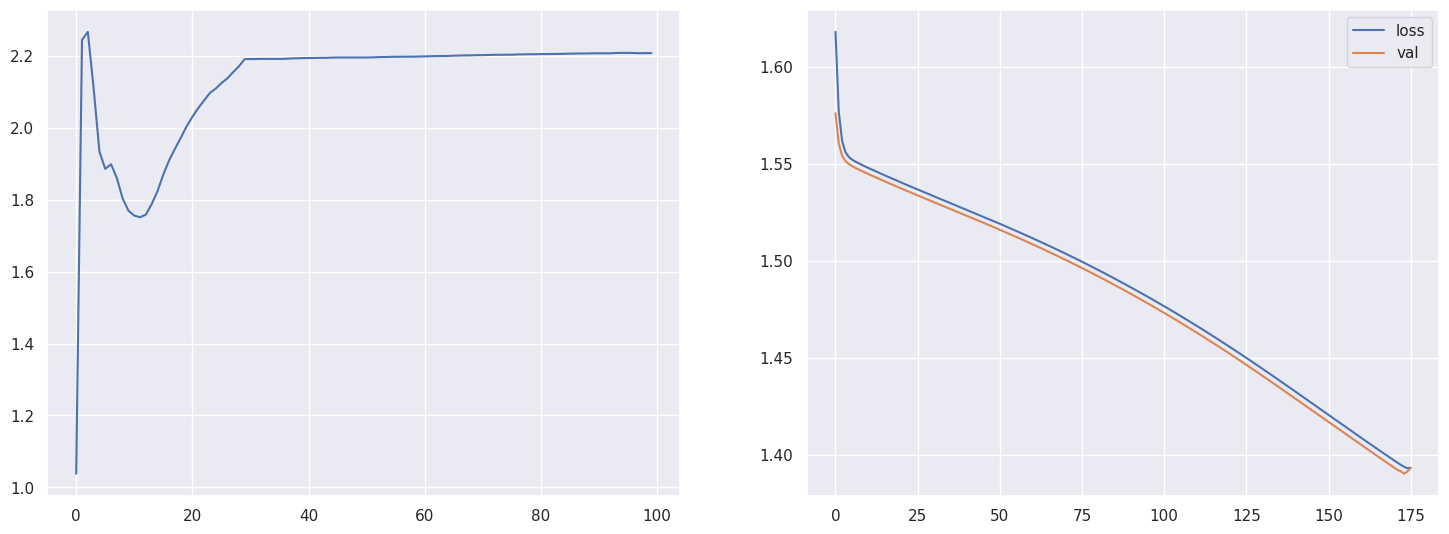

8
9
Final Training Loss: 1.334
Epoch: 182


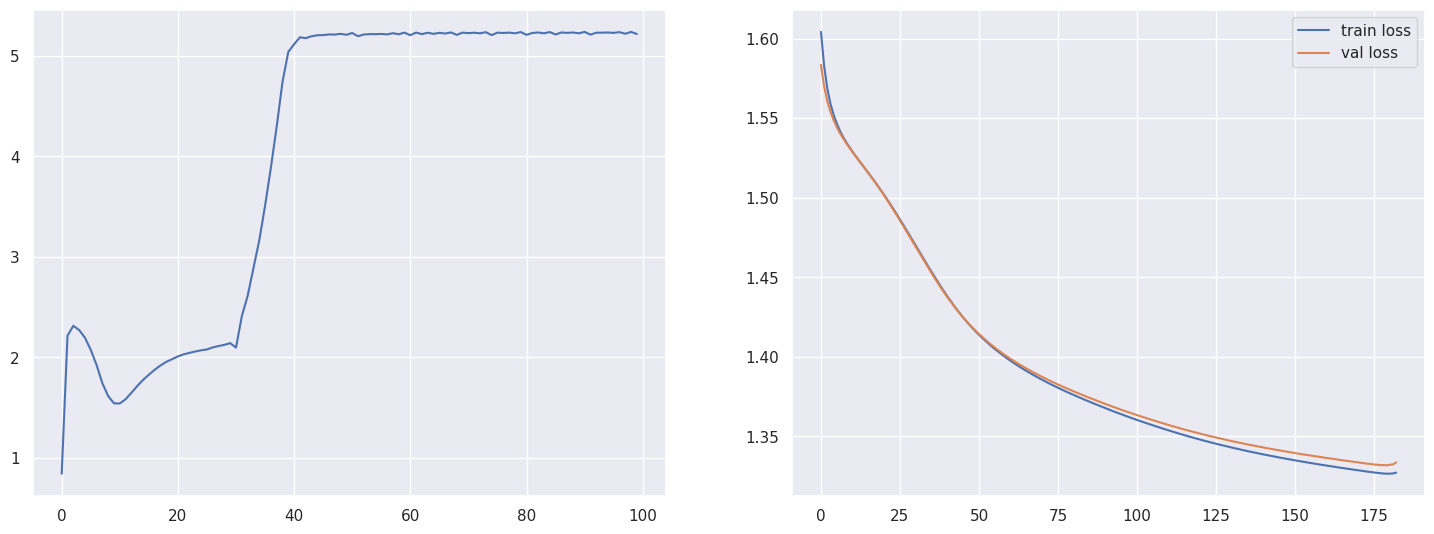

9


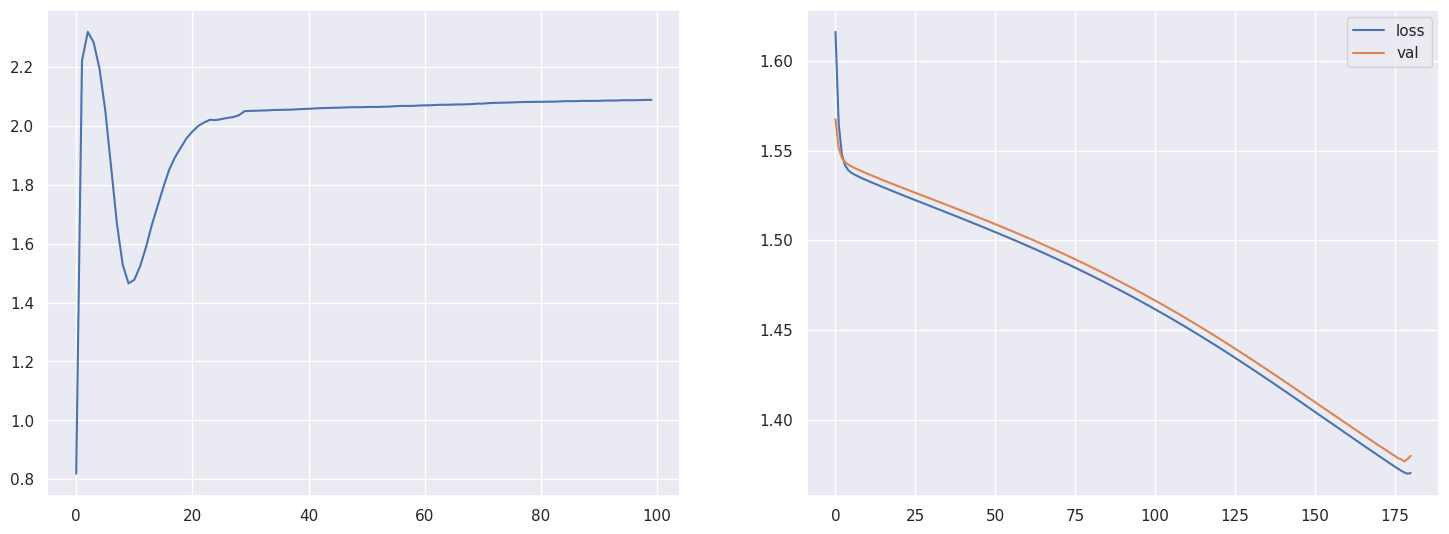

9


In [ ]:
num_epoch = 300
epoch = list(range(T)) * 10

for cost_coef in [0.15, 0.1, 0.05]:
    spg_cv = []    
    e2e_cv = []
    pg_cv = []    
    cutoff_cv = []
    init_seed = 0    
    print(cost_coef)
    
    for rep_index in range(10):
        spg_curve = StrategicGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.2, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H,  len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                
        cutoff_cv.append(cutoff(cost_coef=cost_coef, card_u=card_u, beta=beta, n_eval=n_eval))        
        e2e_curve = End2endGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.05, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)
        pg_curve = VanillaGD(cost_coef=cost_coef, lr_pi=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, T=T, n=n, n_eval=n_eval)

        spg_cv.extend(spg_curve)
        pg_cv.extend(pg_curve)
        e2e_cv.extend(e2e_curve)   

    
    df = pd.DataFrame({'epoch': epoch, "spg": spg_cv, "e2e": e2e_cv, "vani":pg_cv})
    df.to_csv("result/synthetic_nov_c{}_final.csv".format(cost_coef))
    torch.save(cutoff_cv, "result/synthetic_cutoff_c{}_final.pkl".format(cost_coef))
    

# Generate instances

0.15
0


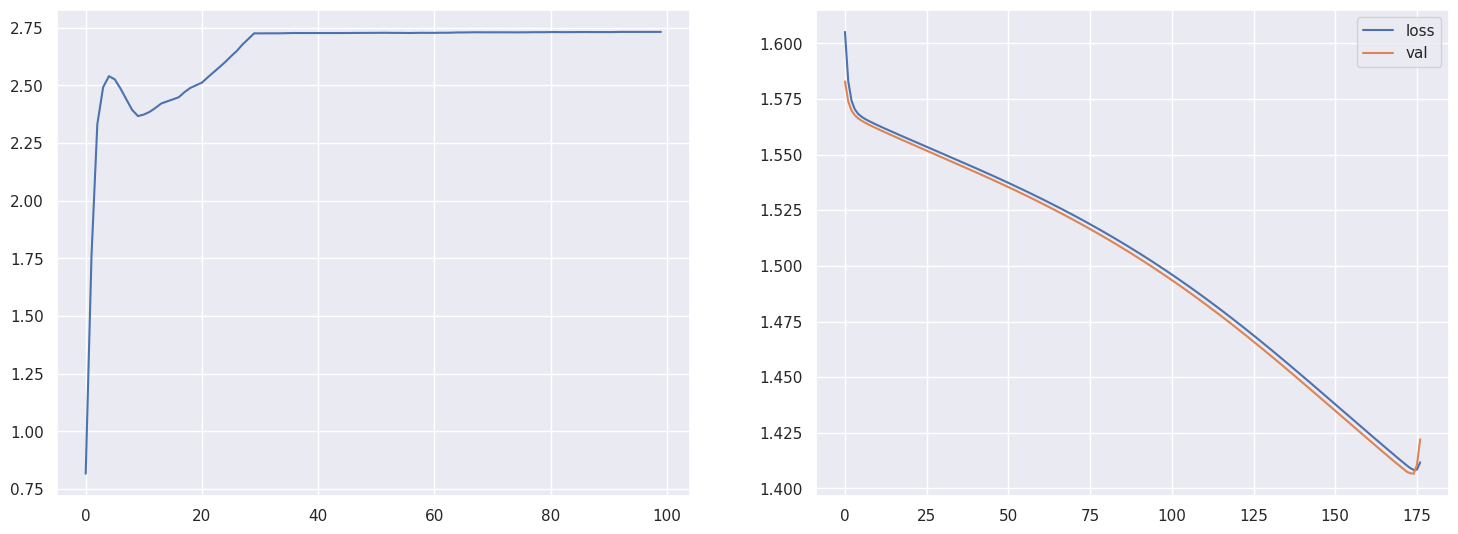

0
0.1
0


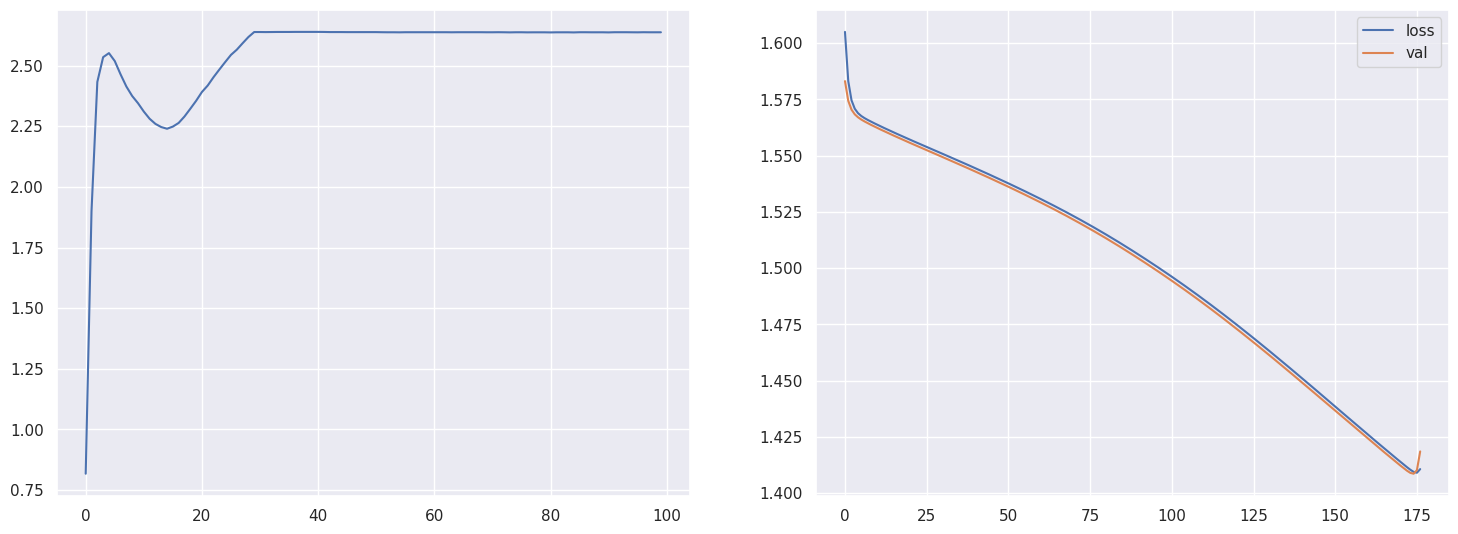

0
0.05
0


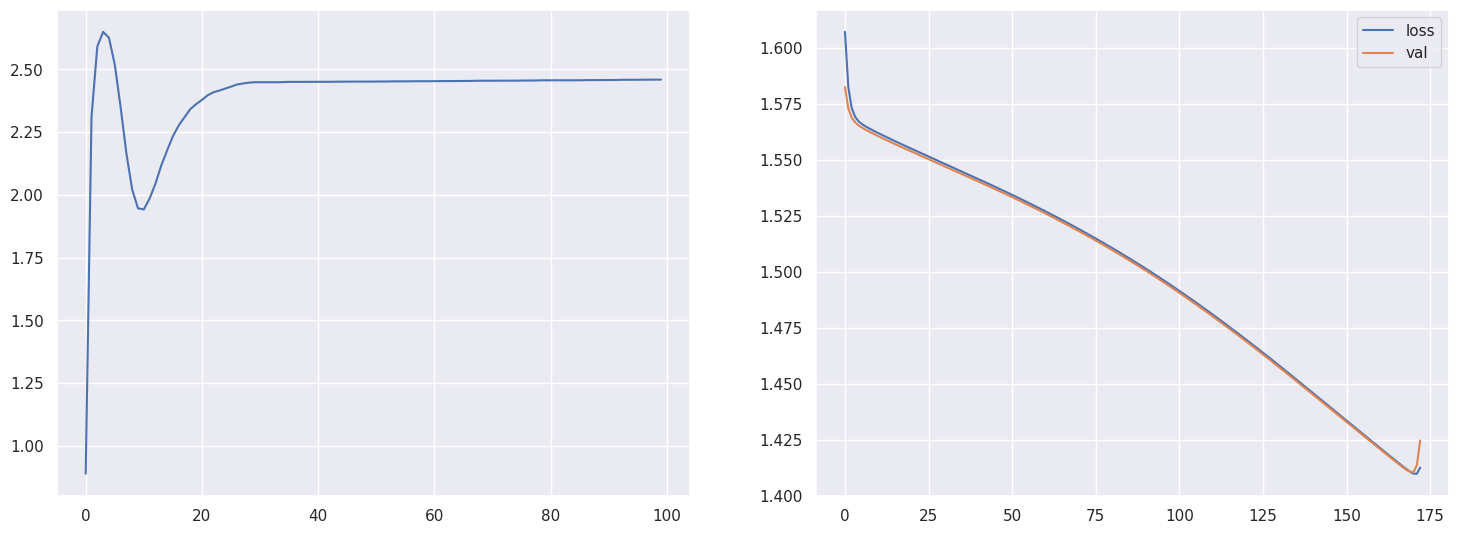

0


In [ ]:
epoch = list(range(T)) * 10

for cost_coef in [0.15, 0.1, 0.05]:
    theta_cv = []
    pg_cv = []
    spg_cv = []
    init_seed = 0
    
    print(cost_coef)
    
    for rep_index in range(1):
        theta_curve = End2endGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.05, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)
        pg_curve = VanillaGD(cost_coef=cost_coef, lr_pi=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, T=T, n=n, n_eval=n_eval)    

0.1
0
Final Training Loss: 1.314
Epoch: 299


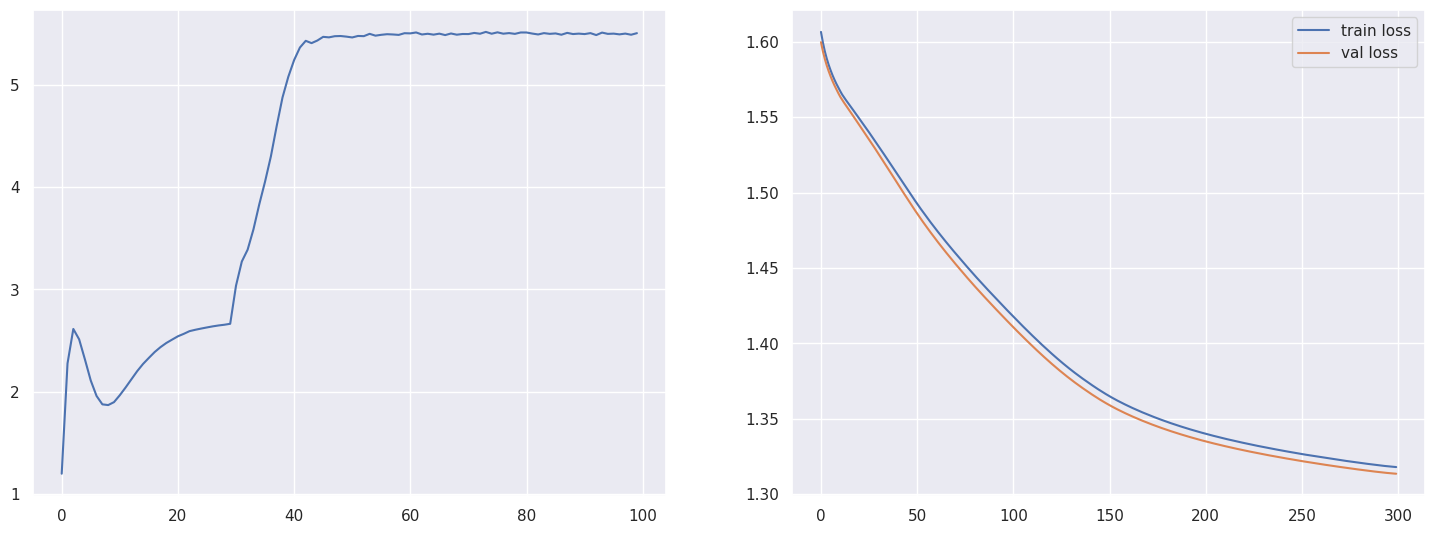

0


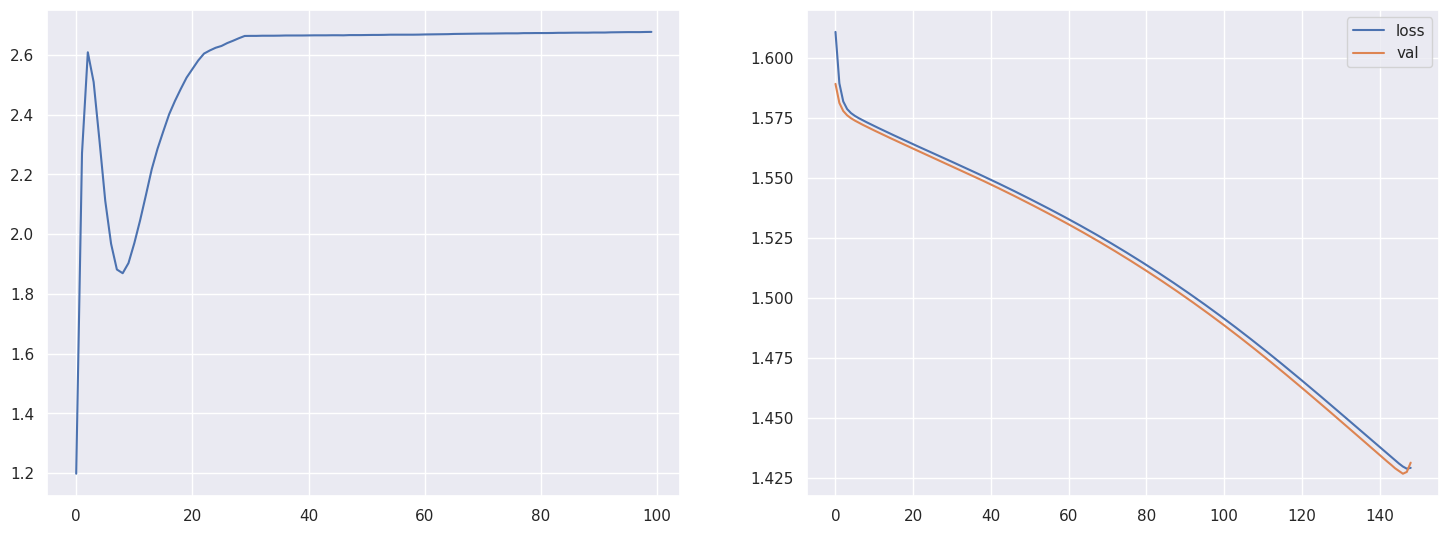

In [ ]:
num_epoch = 300
epoch = list(range(T)) * 10

for cost_coef in [0.1]:
    init_seed = 0
    print(cost_coef)
    
    for rep_index in range(1):
        spg_curve = StrategicGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.2, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                
        theta_curve = End2endGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.05, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)
